# Dataset

In [2]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## Data Manipulation and Data Clearning

In [3]:
data = hddm.load_csv('/home/jovyan/work/NbackData.csv', skiprows=1)

In [4]:
data_rename = data.rename(columns={
    "Stim.RT": "rt",      
    "Subject": "subj_idx", 
    "Stim.ACC": "response" 
})

In [5]:
data_select_col = data_rename[['subj_idx', 'rt', 'response', 'BlockType','StimType','TargetType']]

In [6]:
data_filtered = data_select_col[(data_rename['rt'] > 150)].dropna()

In [7]:
dataset = pd.DataFrame()  # Initialize an empty DataFrame
dataset=data_filtered[['subj_idx', 'rt', 'response', 'BlockType','StimType','TargetType']]
dataset['rt'] = data_filtered['rt'] / 1000  # Convert 'rt' to seconds
dataset['Stim_cog_emo'] = np.where(data_filtered['StimType'].isin(["NegFace", "PosFace"]), "Affective", "Cognitive")

# Print the new dataset
print(dataset)

       subj_idx     rt  response BlockType StimType TargetType Stim_cog_emo
2         11684  1.340       1.0    0-Back  NegFace    nonlure    Affective
3         11684  1.835       1.0    0-Back  NegFace    nonlure    Affective
4         11684  1.544       1.0    0-Back  NegFace     target    Affective
5         11684  1.167       1.0    0-Back  NegFace       lure    Affective
6         11684  0.999       1.0    0-Back  NegFace    nonlure    Affective
...         ...    ...       ...       ...      ...        ...          ...
46344     12484  0.636       1.0    0-Back  NegFace     target    Affective
46345     12484  0.438       1.0    0-Back  NegFace       lure    Affective
46346     12484  0.338       1.0    0-Back  NegFace    nonlure    Affective
46347     12484  0.393       1.0    0-Back  NegFace       lure    Affective
46348     12484  0.716       1.0    0-Back  NegFace    nonlure    Affective

[34888 rows x 7 columns]


In [8]:
print("The number of trials: ", dataset.shape[0])
print("The number of variables: ", dataset.shape[1])  # This should now work
print("The number of participants: ", dataset['subj_idx'].unique().shape[0])  # Ensure subj_idx is in dataset


The number of trials:  34888
The number of variables:  7
The number of participants:  259


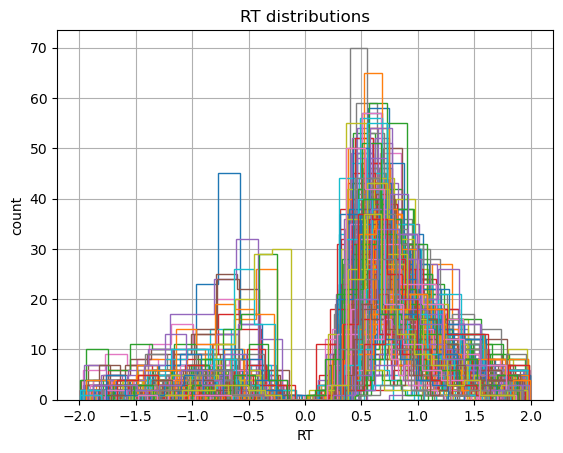

In [9]:

data = hddm.utils.flip_errors(dataset)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# Modeling

## Prior Check

In [10]:
hddm.model_config.model_config["ddm"]

{'doc': 'Basic DDM. Meant for use with the LAN extension. \nNote that the boundaries here are coded as -a, and a in line with all other models meant for the LAN extension. \nTo compare model fits between standard HDDM and HDDMnn when using the DDM model, multiply the boundary (a) parameter by 2. \nWe recommend using standard HDDM if you are interested in the basic DDM, but you might want to use this for testing.',
 'params': ['v', 'a', 'z', 't'],
 'params_trans': [0, 0, 1, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001], [3.0, 2.5, 0.9, 2.0]],
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'params_default': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['v', 'a', 't', 'z'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15}}

## Model for individual with BlockType * Stim_cog_emo conditions

In [12]:
models = []
# Fit 5 HDDM models
for i in range(5):
    m = hddm.HDDM(dataset, 
                  include=['a', 'v', 't','z'], 
                  depends_on={'v': ['BlockType', 'Stim_cog_emo'],
                              'a': ['BlockType', 'Stim_cog_emo'],
                              't': ['BlockType', 'Stim_cog_emo'],
                              'z': ['BlockType', 'Stim_cog_emo']},
                  informative=True,
                  is_group_model=True,
                  )
    
    # Find starting values and sample from the posterior
    m.find_starting_values()
    m.sample(10000, burn=4000)
    
    # Append the fitted model to the list
    models.append(m)

# Perform Gelman-Rubin diagnostic
gelman_rubin_results = hddm.analyze.gelman_rubin(models)


No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 16212.2 sechddm sampling elpased time:  16217.849 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 13017.9 sechddm sampling elpased time:  13023.783 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 12962.8 sechddm sampling elpased time:  12968.495 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 12945.2 sechddm sampling elpased time:  12950.974 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 14930.3 sechddm sampling elpased time:  14936.114 s


## Result

In [ ]:
# @title Print R_hat for convergence check
# Convert the Gelman-Rubin results to a DataFrame
gelman_rubin_results = pd.DataFrame.from_dict(gelman_rubin_results, orient='index', columns=['Gelman-Rubin'])

# Reset the index so the 'subject_id' becomes a column
gelman_rubin_results.reset_index(inplace=True)

# Rename the index column to 'subject_id'
gelman_rubin_results.rename(columns={'index': 'subject_id'}, inplace=True)

# Save the DataFrame to a CSV
gelman_rubin_results.to_csv('gelman_rubin_results.csv', index=False)

In [15]:
# @title Print Model Summery
for i, model in enumerate(models):
    print(f"Model {i+1} statistics:")
    print(model.gen_stats())
    
model_stats_summary= pd.DataFrame(model.gen_stats())
model_stats_summary.reset_index(inplace=True)

# Rename the index column to 'subject_id'
model_stats_summary.rename(columns={'index': 'subject_id'}, inplace=True)

# Save the DataFrame to a CSV file
model_stats_summary.to_csv('model_stats_summary.csv', index=False) 

Model 1 statistics:
                                    mean       std      2.5q       25q   
a(0-Back.Affective)             1.781864  0.022344  1.737911  1.767027  \
a(0-Back.Cognitive)             1.826426  0.022773  1.781723  1.810951   
a(2-Back.Affective)             1.776499  0.021315  1.734625  1.762223   
a(2-Back.Cognitive)             1.795977  0.021695  1.753145  1.781228   
a_std                           0.248541  0.011336  0.227285  0.240862   
...                                  ...       ...       ...       ...   
z_subj(2-Back.Cognitive).12480  0.468095   0.01454  0.439349  0.458967   
z_subj(2-Back.Cognitive).12481  0.466743  0.014547  0.437383  0.458029   
z_subj(2-Back.Cognitive).12482  0.466965  0.014397  0.436995  0.458359   
z_subj(2-Back.Cognitive).12483  0.466702  0.014485  0.437851  0.457947   
z_subj(2-Back.Cognitive).12484  0.461627  0.014894  0.429142  0.453272   

                                     50q       75q     97.5q    mc err  
a(0-Back.Affective

In [37]:
# @title Merge Dataset
merged_models = pd.merge(model_stats_summary, gelman_rubin_results, on='subject_id', how='inner')  # Use 'inner' for only matching rows

# Save the merged DataFrame to a CSV file
merged_models.to_csv('merged_models.csv', index=False)
print(merged_models)

                          subject_id      mean       std      2.5q       25q   
0                a(0-Back.Affective)  1.781784  0.022648  1.737657  1.766428  \
1                a(0-Back.Cognitive)  1.827839  0.023888  1.781292  1.811682   
2                a(2-Back.Affective)  1.775864  0.021752  1.732559  1.761385   
3                a(2-Back.Cognitive)  1.797441  0.021217  1.756718  1.782906   
4                              a_std  0.249653  0.011585  0.228181  0.241695   
...                              ...       ...       ...       ...       ...   
3119  t_subj(2-Back.Cognitive).12481  0.334402  0.035259  0.259956  0.311477   
3120  t_subj(2-Back.Cognitive).12482  0.320944  0.032633  0.251125   0.29991   
3121  t_subj(2-Back.Cognitive).12483  0.315376  0.030851  0.249179  0.295918   
3122  t_subj(2-Back.Cognitive).12484  0.269148  0.032726   0.20757  0.248076   
3123                           z_std  0.056869  0.023631  0.020065  0.039027   

           50q       75q     97.5q    m

In [38]:
filtered_data = merged_models[
    merged_models['subject_id'].isin([
        'a(0-Back.Affective)', 
        'a(0-Back.Cognitive)', 
        'a(2-Back.Affective)', 
        'a(2-Back.Cognitive)',
        'v(0-Back.Affective)',
        'v(0-Back.Cognitive)',
        'v(2-Back.Affective)', 
        'v(2-Back.Cognitive)',
        't(0-Back.Affective)', 
        't(0-Back.Cognitive)', 
        't(2-Back.Affective)', 
        't(2-Back.Cognitive)',
        'z(0-Back.Affective)',
        'z(0-Back.Cognitive)',
        'z(2-Back.Affective)', 
        'z(2-Back.Cognitive)',
    ])]
print(filtered_data)

               subject_id      mean       std      2.5q       25q       50q   
0     a(0-Back.Affective)  1.781784  0.022648  1.737657  1.766428  1.781616  \
1     a(0-Back.Cognitive)  1.827839  0.023888  1.781292  1.811682  1.827678   
2     a(2-Back.Affective)  1.775864  0.021752  1.732559  1.761385  1.776008   
3     a(2-Back.Cognitive)  1.797441  0.021217  1.756718  1.782906  1.796964   
1041  v(0-Back.Affective)  1.708849  0.055056  1.603041  1.672002  1.708405   
1042  v(0-Back.Cognitive)  1.913756  0.055841  1.806287  1.874761  1.913222   
1043  v(2-Back.Affective)  1.281662  0.053605  1.177186  1.245258  1.281697   
1044  v(2-Back.Cognitive)  1.289031  0.053785  1.182983  1.252846  1.289183   
2082  t(0-Back.Affective)  0.322684  0.006343  0.310026  0.318439  0.322744   
2083  t(0-Back.Cognitive)  0.319041  0.006588  0.306074  0.314609  0.319017   
2084  t(2-Back.Affective)  0.366622  0.007028  0.352604  0.361925  0.366589   
2085  t(2-Back.Cognitive)  0.380898  0.007018  0.366

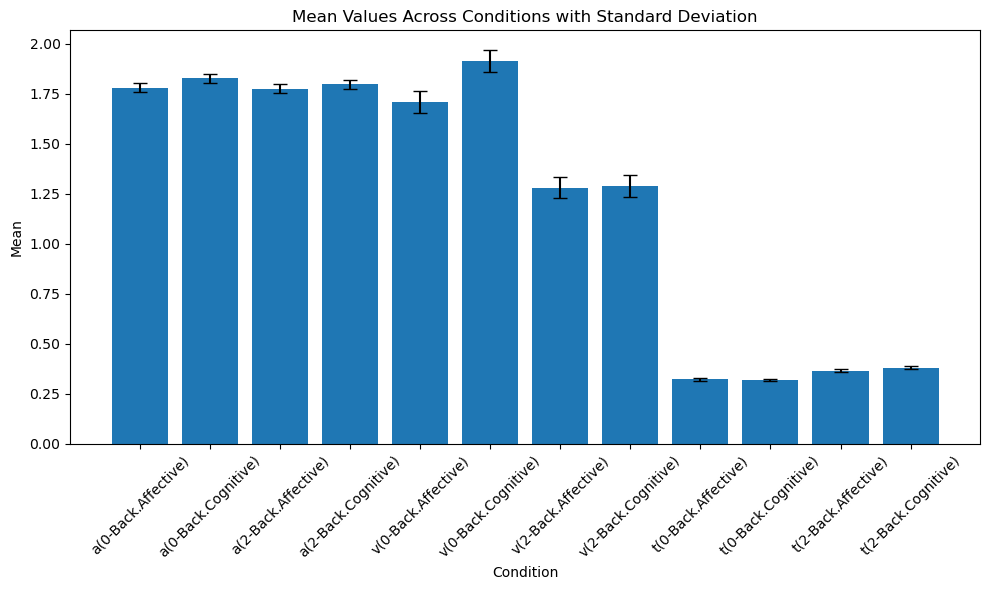

In [43]:
# Create a bar plot for the mean values
plt.figure(figsize=(10, 6))
plt.bar(filtered_data['subject_id'], filtered_data['mean'], yerr=filtered_data['std'], capsize=5)
plt.xticks(rotation=45)
plt.xlabel('Condition')
plt.ylabel('Mean')
plt.title('Mean Values Across Conditions with Standard Deviation')
plt.tight_layout()
plt.show()

# Posterior Visualization

Plotting posteriors for Model 1...
Plotting a(0-Back.Affective)
Plotting a(0-Back.Cognitive)
Plotting a(2-Back.Affective)
Plotting a(2-Back.Cognitive)
Plotting v(0-Back.Affective)
Plotting v(0-Back.Cognitive)
Plotting v(2-Back.Affective)
Plotting v(2-Back.Cognitive)
Plotting t(0-Back.Affective)
Plotting t(0-Back.Cognitive)
Plotting t(2-Back.Affective)
Plotting t(2-Back.Cognitive)


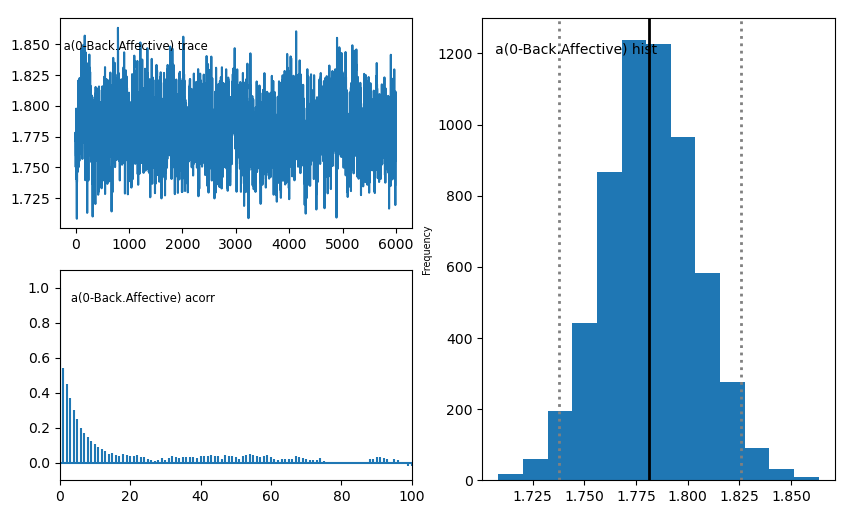

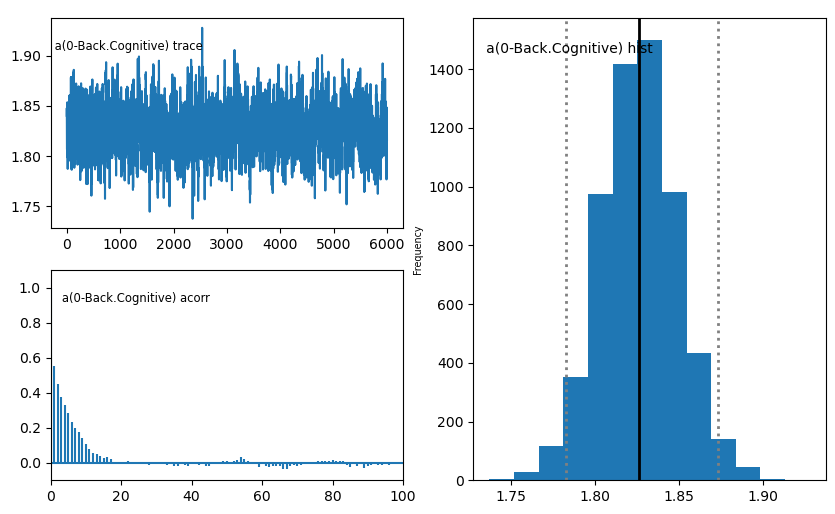

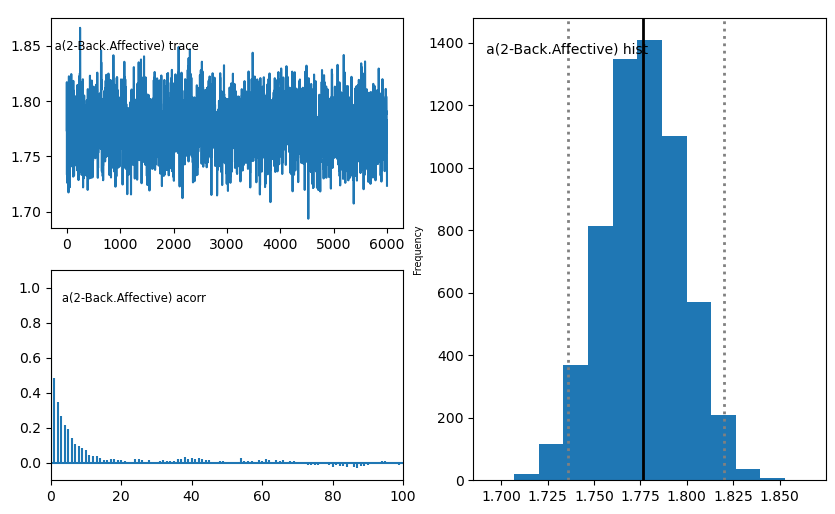

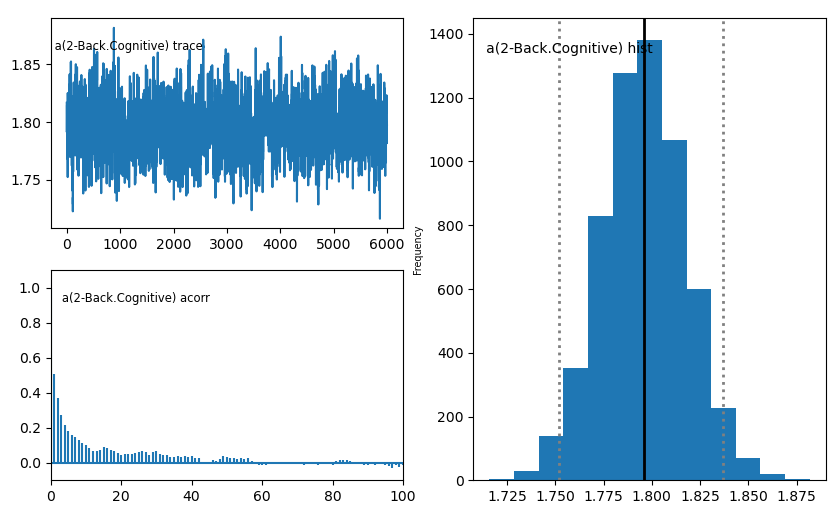

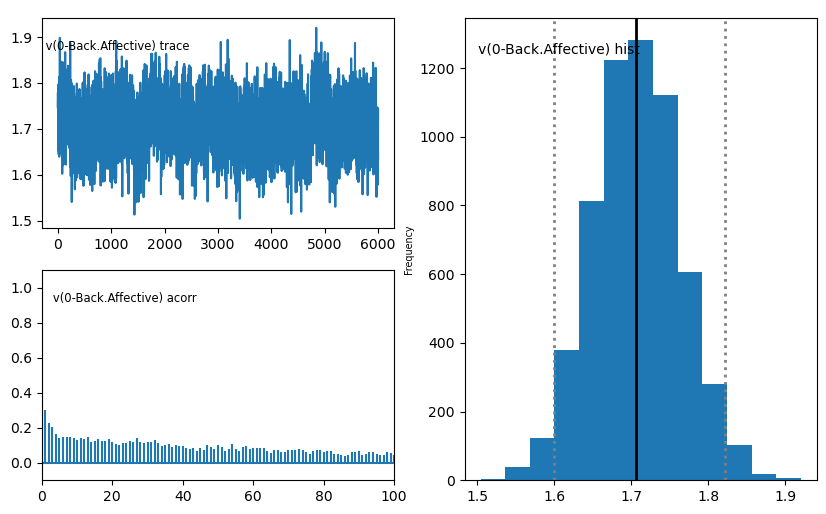

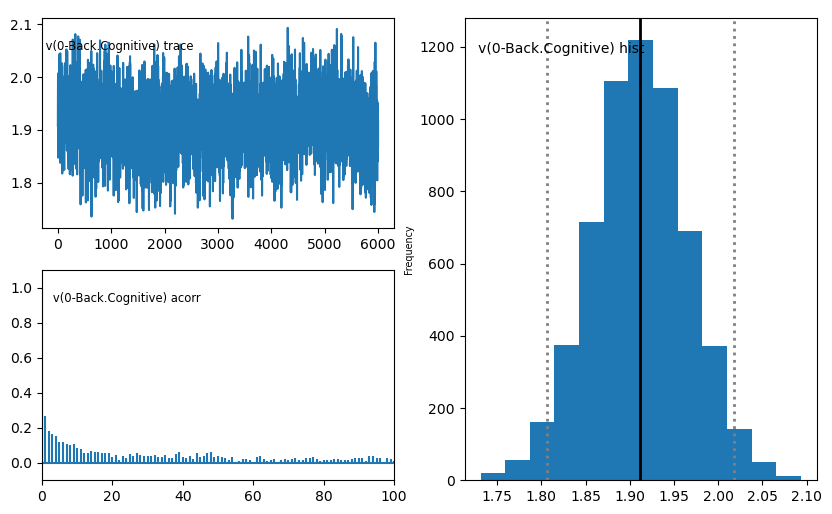

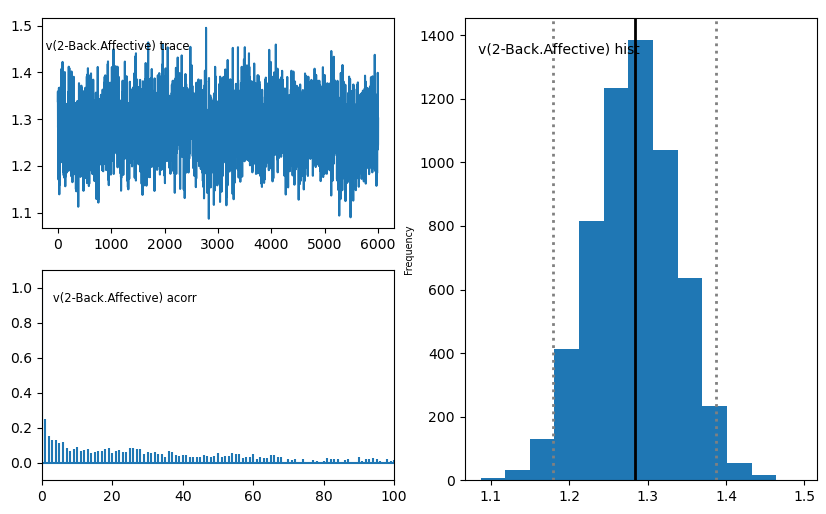

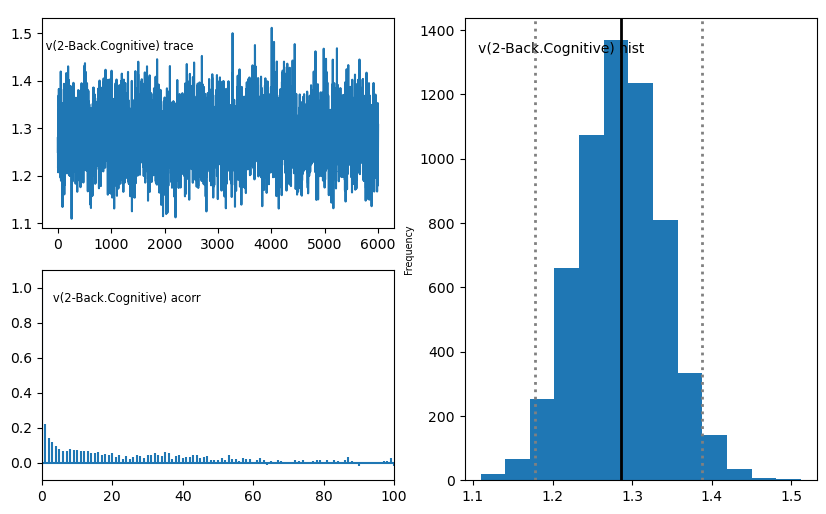

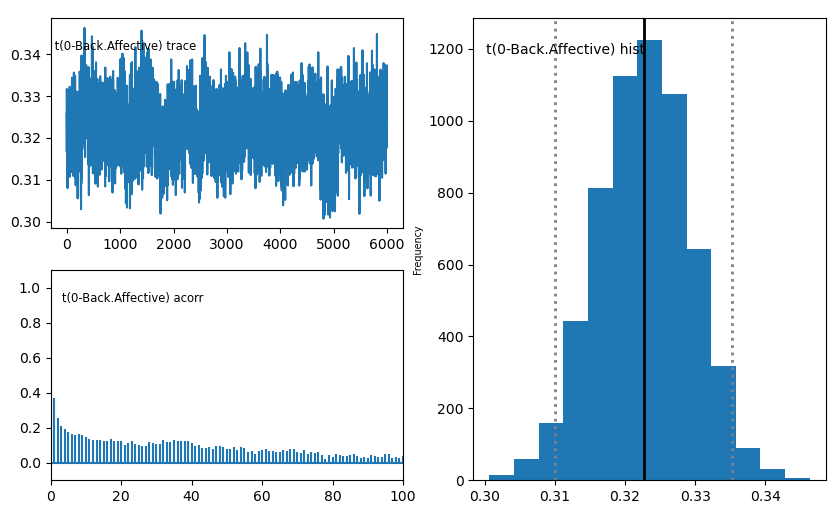

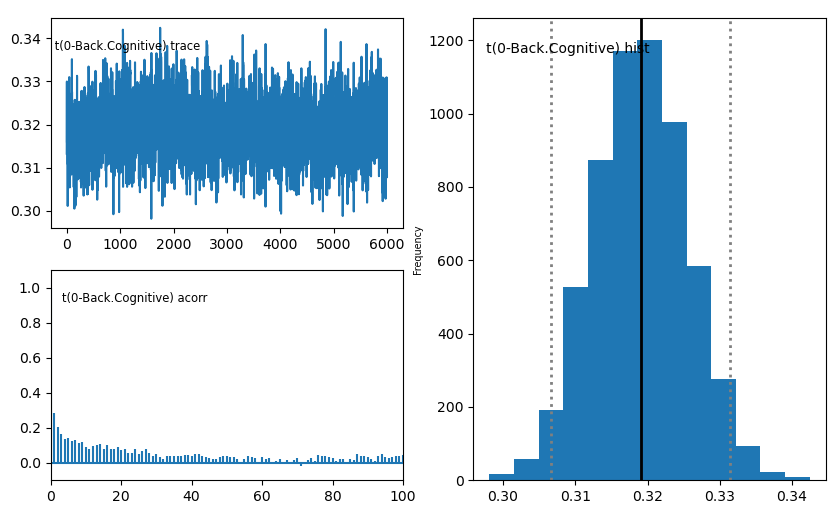

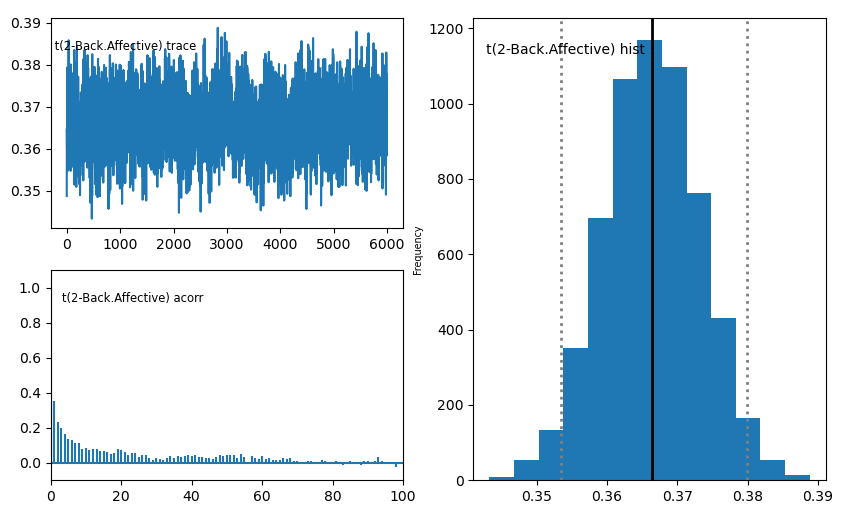

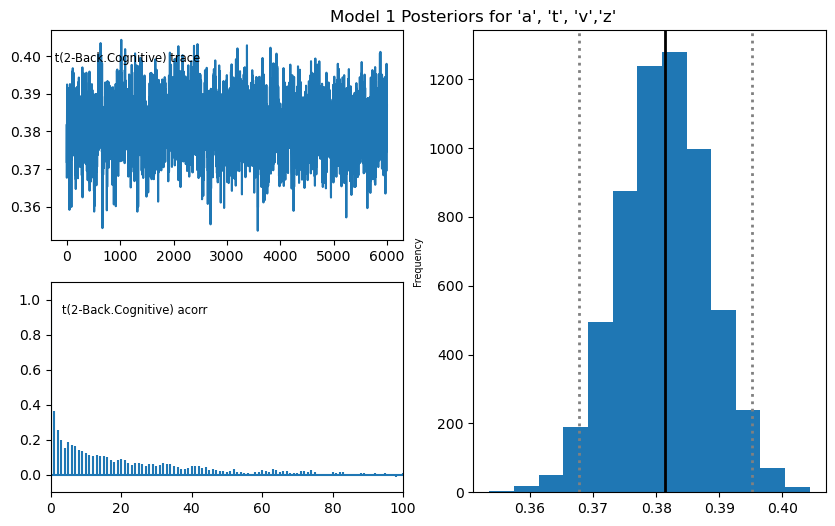

Plotting posteriors for Model 2...
Plotting a(0-Back.Affective)
Plotting a(0-Back.Cognitive)
Plotting a(2-Back.Affective)
Plotting a(2-Back.Cognitive)
Plotting v(0-Back.Affective)
Plotting v(0-Back.Cognitive)
Plotting v(2-Back.Affective)
Plotting v(2-Back.Cognitive)
Plotting t(0-Back.Affective)
Plotting t(0-Back.Cognitive)
Plotting t(2-Back.Affective)
Plotting t(2-Back.Cognitive)


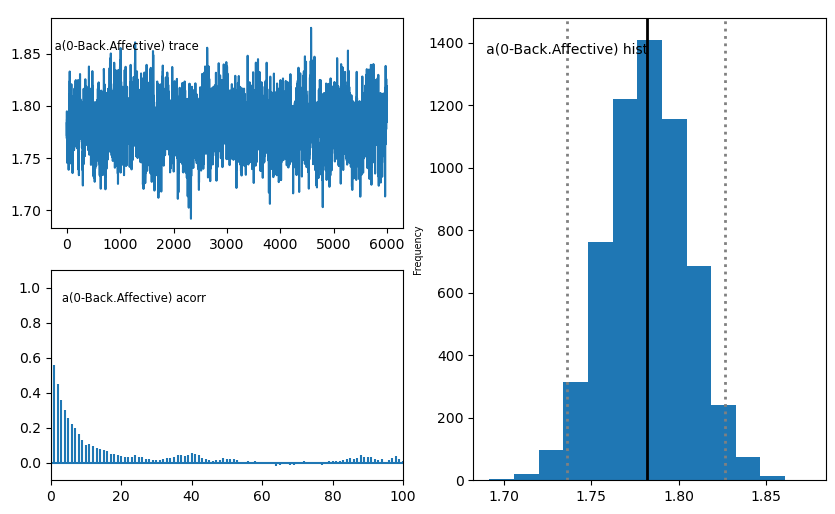

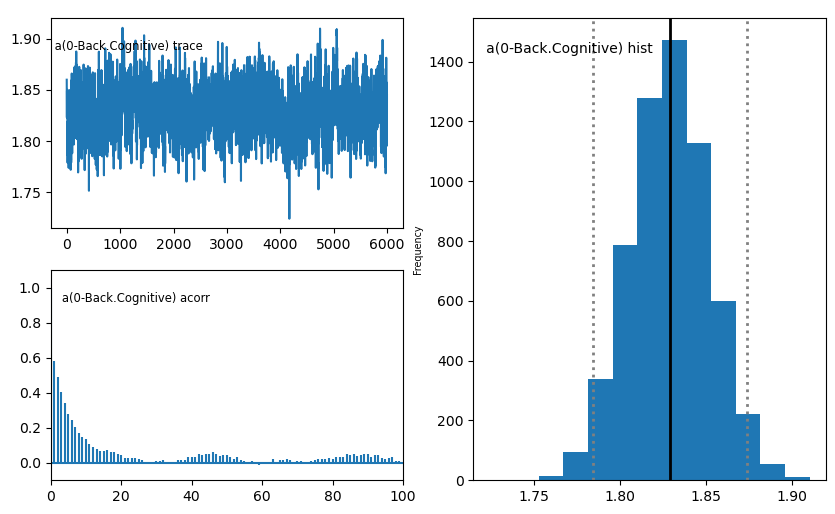

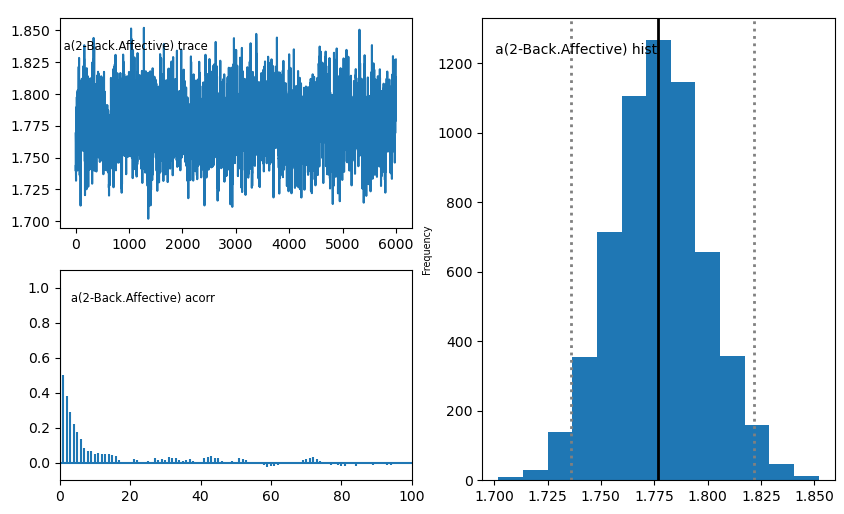

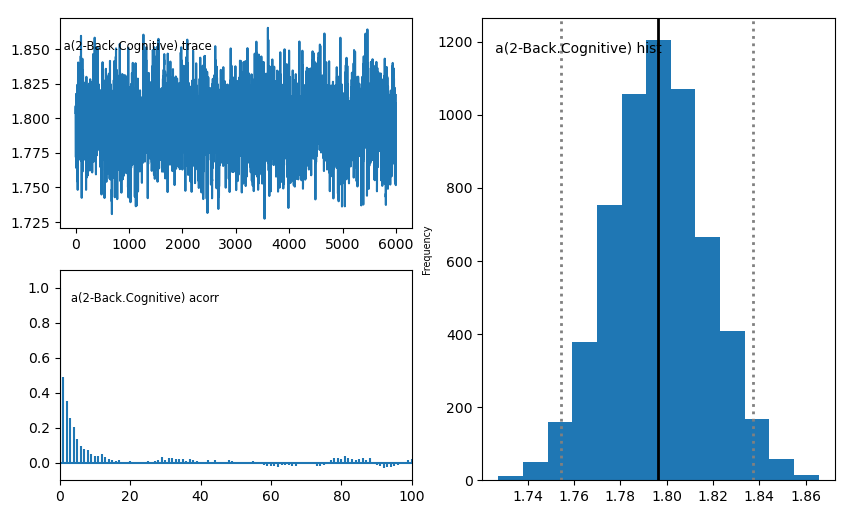

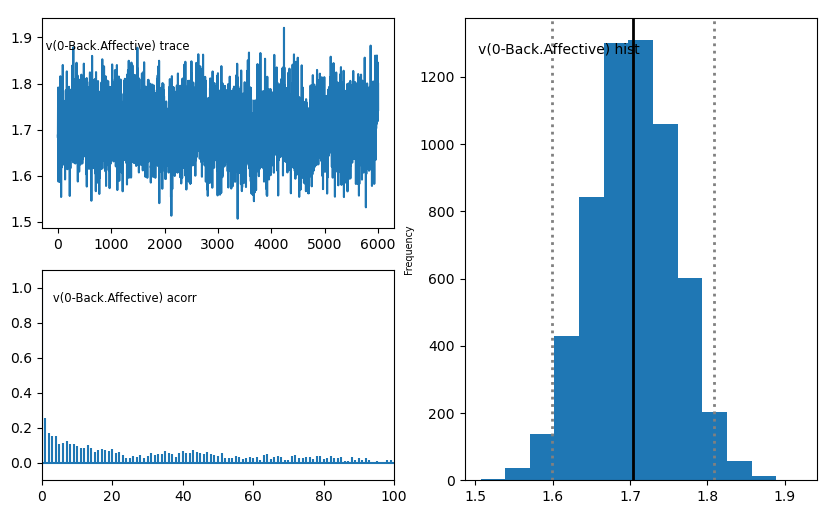

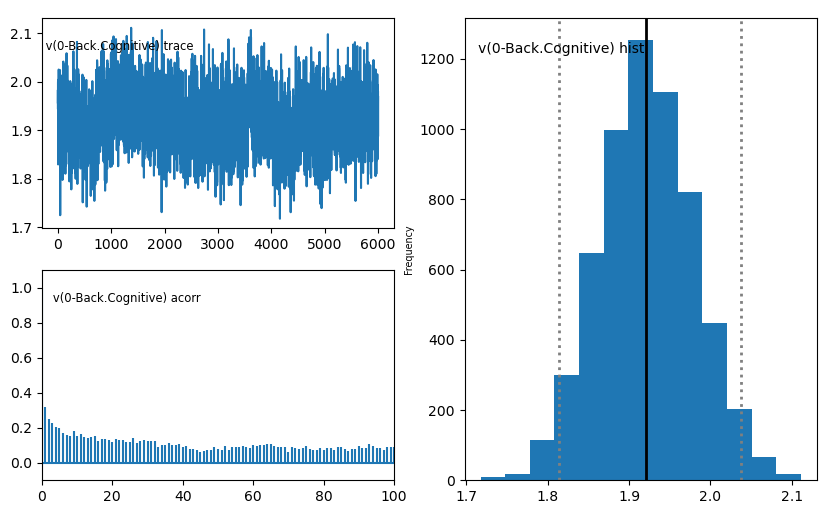

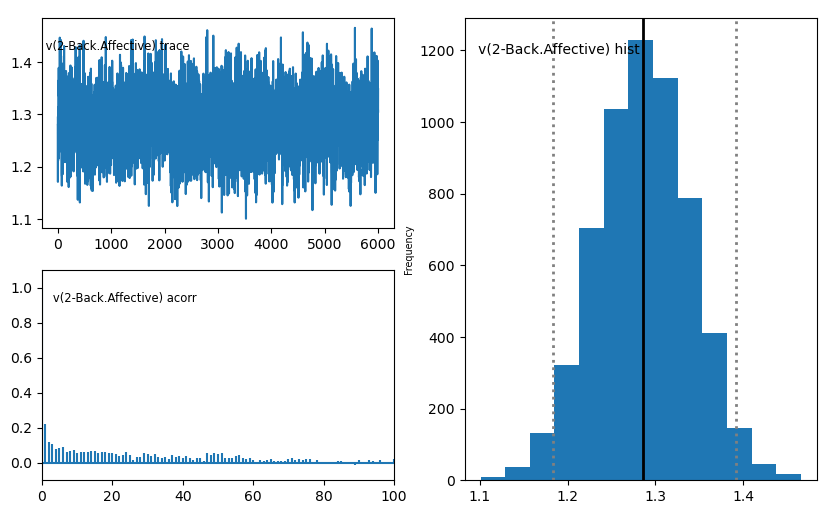

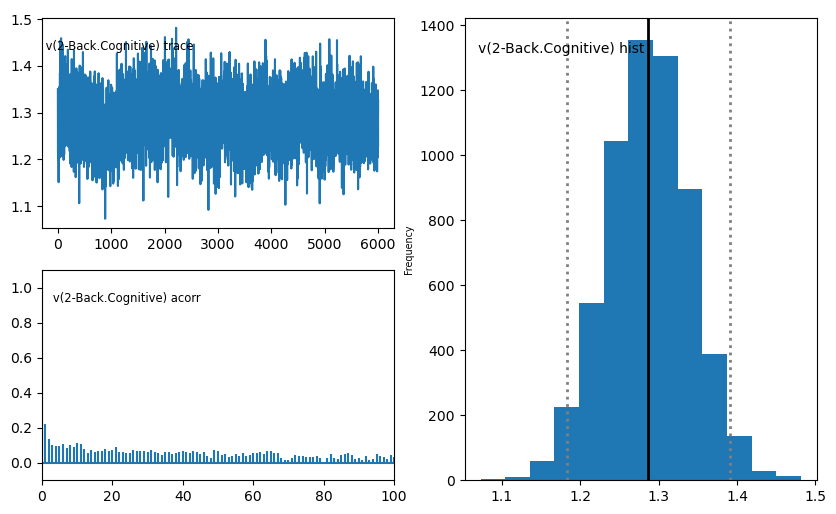

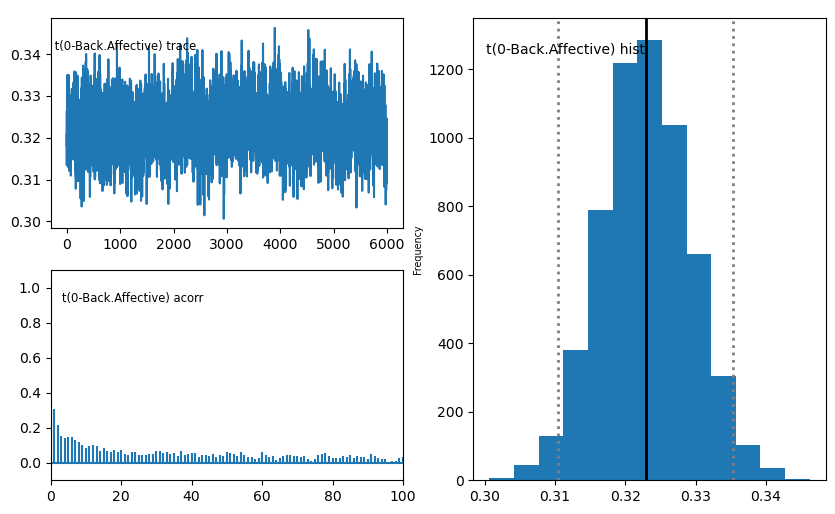

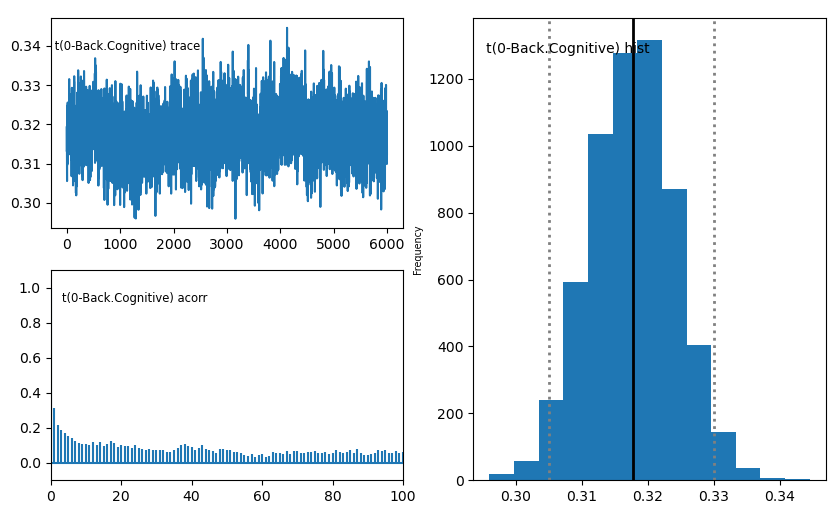

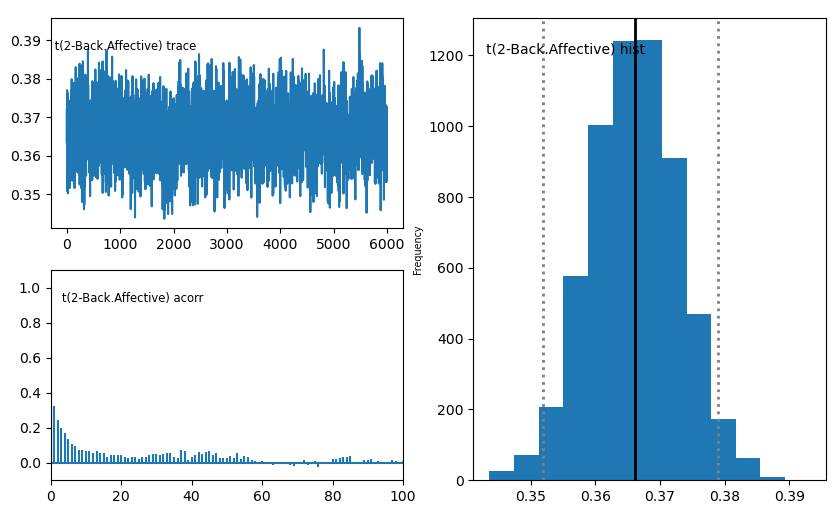

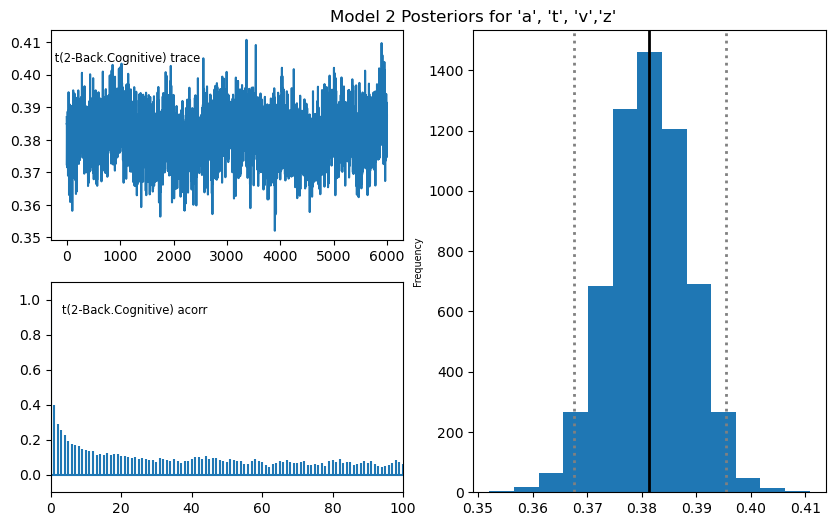

Plotting posteriors for Model 3...
Plotting a(0-Back.Affective)
Plotting a(0-Back.Cognitive)
Plotting a(2-Back.Affective)
Plotting a(2-Back.Cognitive)
Plotting v(0-Back.Affective)
Plotting v(0-Back.Cognitive)
Plotting v(2-Back.Affective)
Plotting v(2-Back.Cognitive)
Plotting t(0-Back.Affective)
Plotting t(0-Back.Cognitive)
Plotting t(2-Back.Affective)
Plotting t(2-Back.Cognitive)


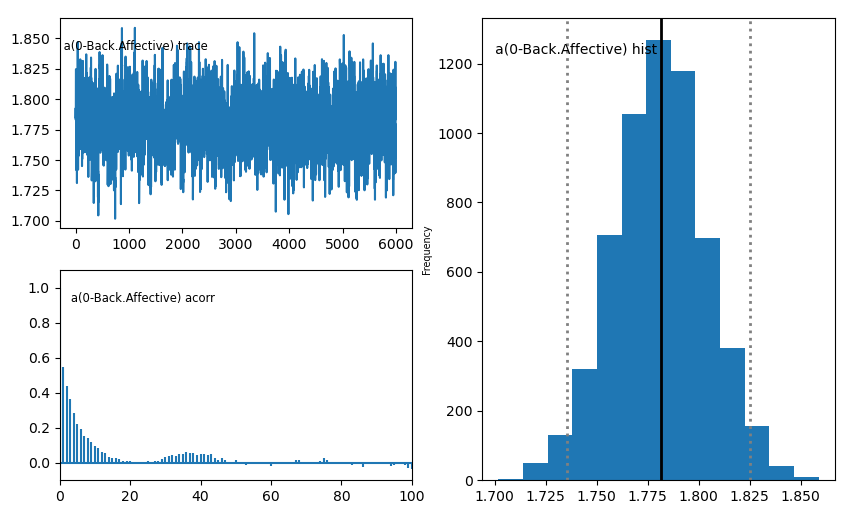

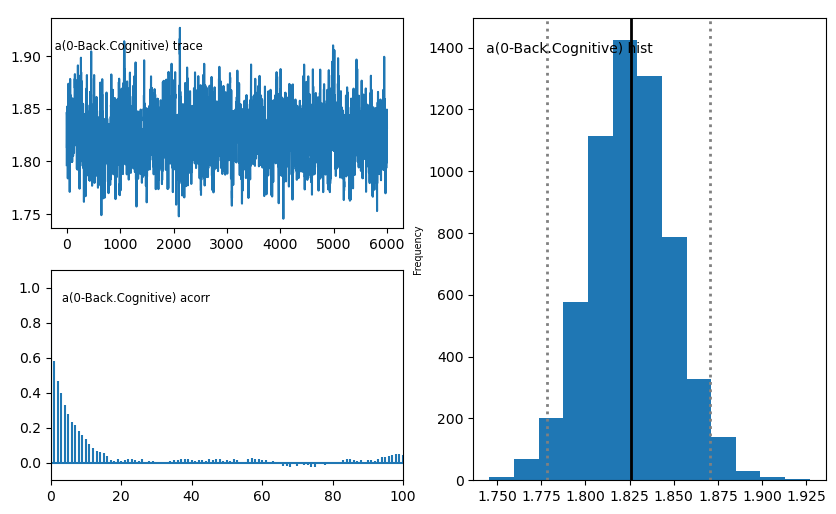

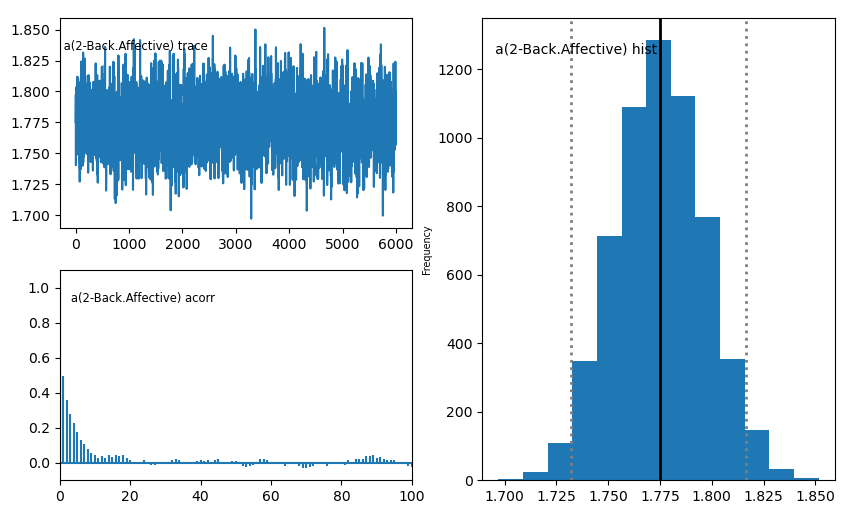

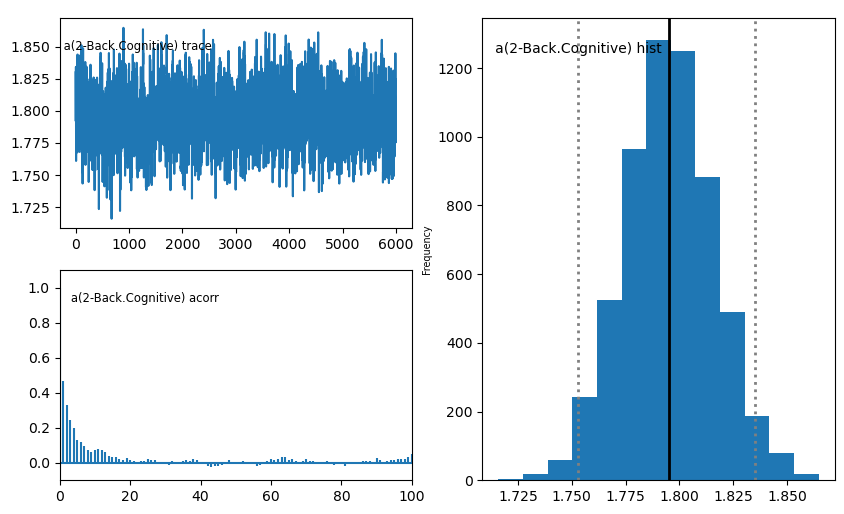

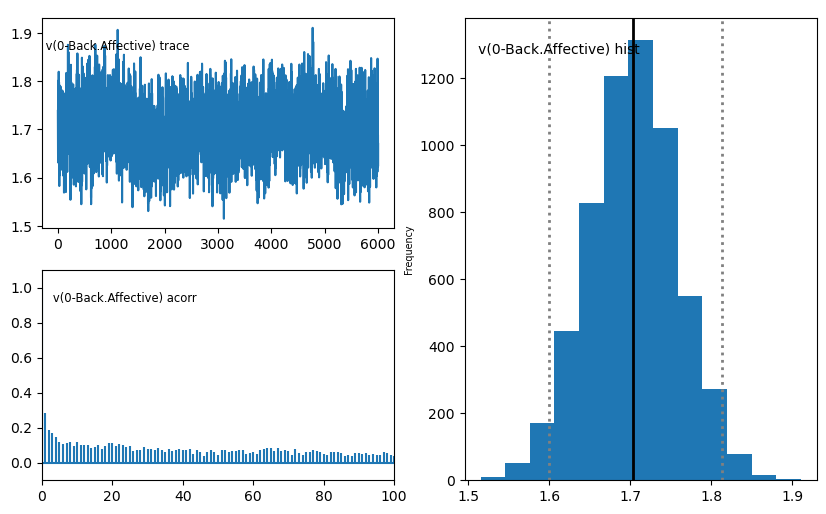

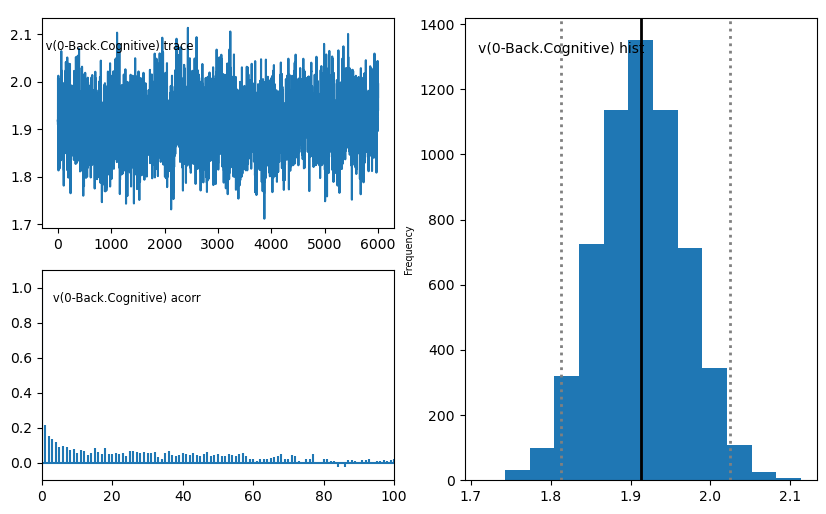

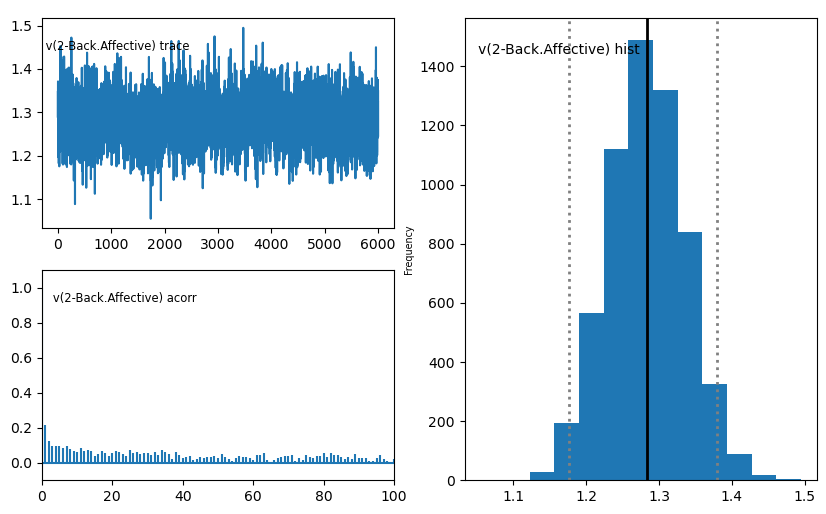

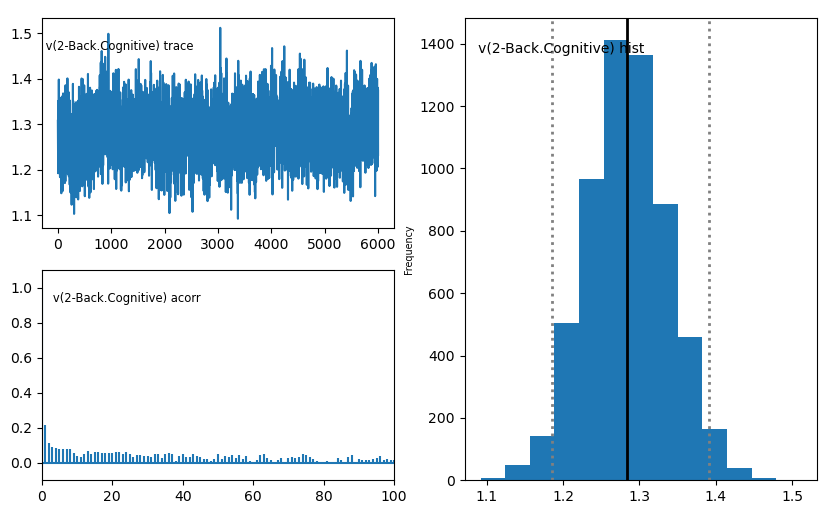

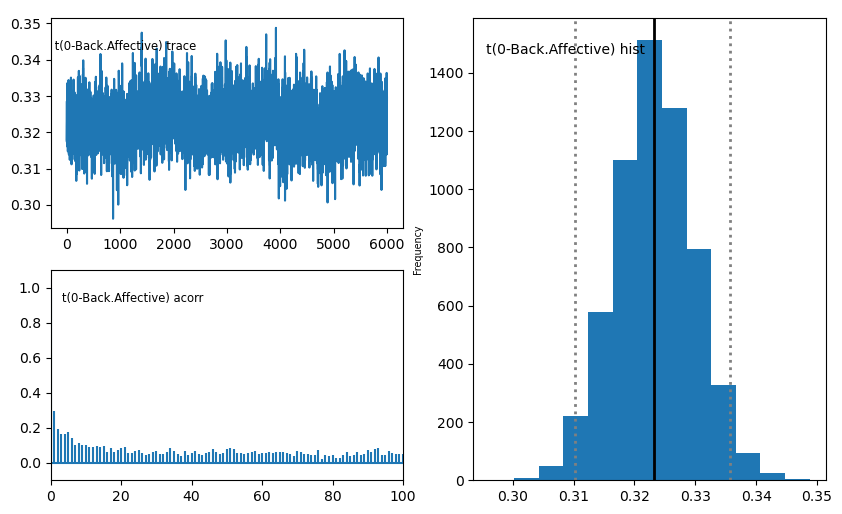

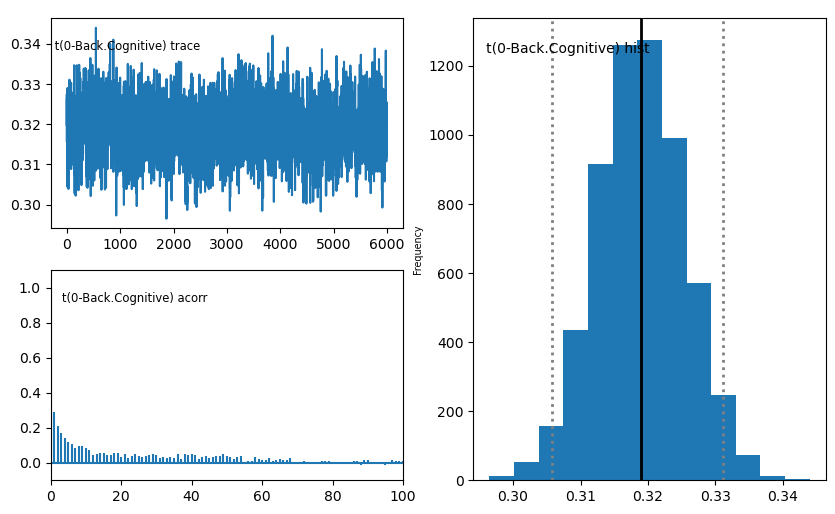

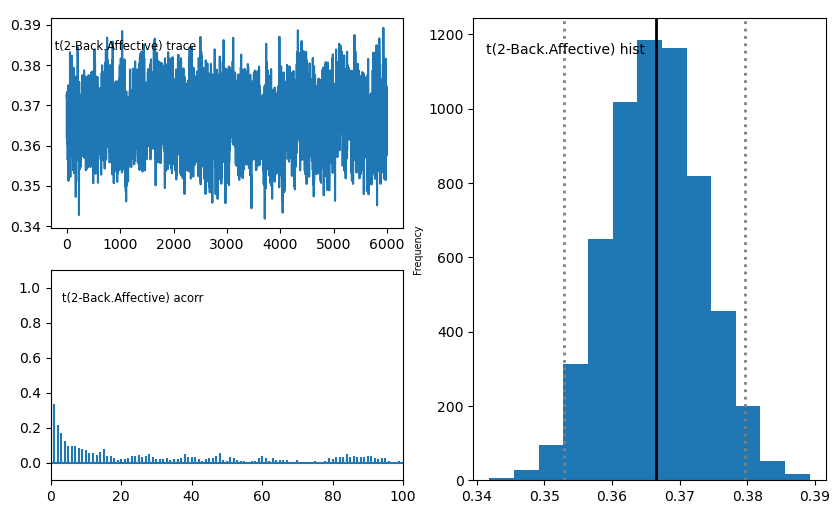

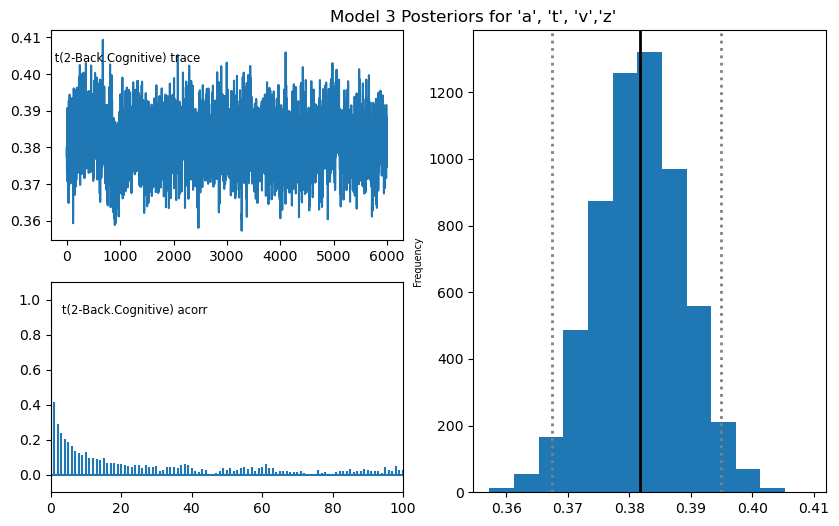

Plotting posteriors for Model 4...
Plotting a(0-Back.Affective)
Plotting a(0-Back.Cognitive)
Plotting a(2-Back.Affective)
Plotting a(2-Back.Cognitive)
Plotting v(0-Back.Affective)
Plotting v(0-Back.Cognitive)
Plotting v(2-Back.Affective)
Plotting v(2-Back.Cognitive)
Plotting t(0-Back.Affective)
Plotting t(0-Back.Cognitive)
Plotting t(2-Back.Affective)
Plotting t(2-Back.Cognitive)


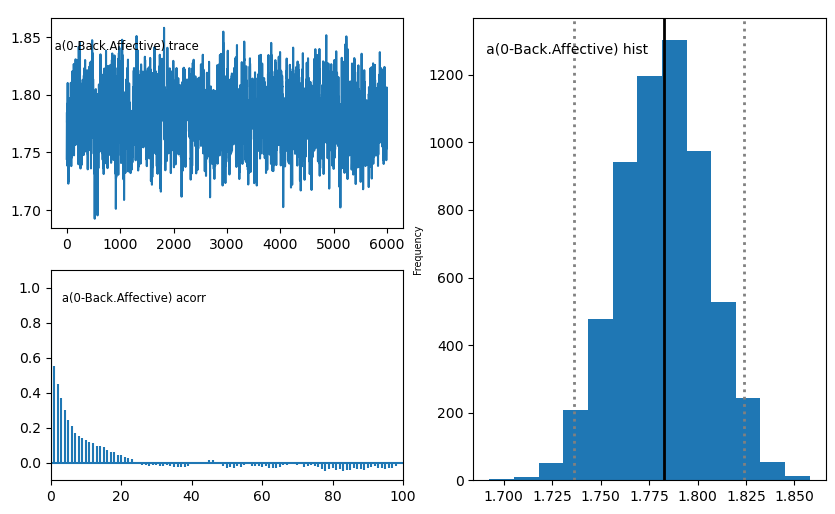

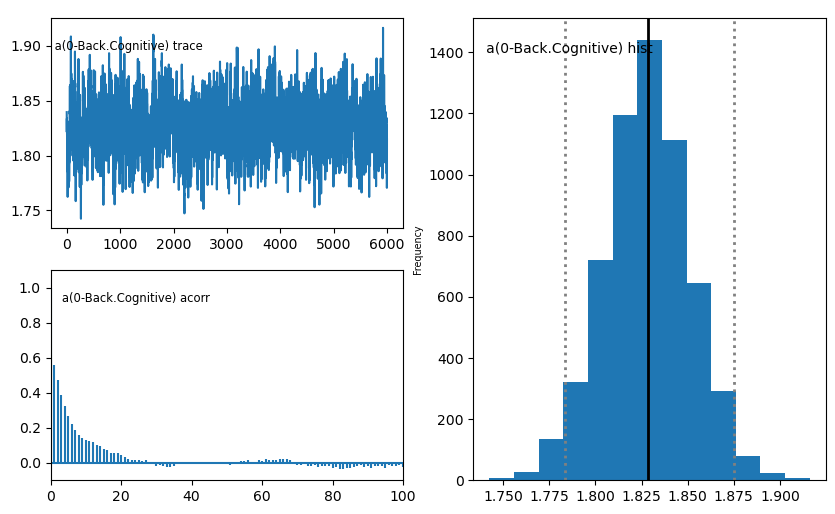

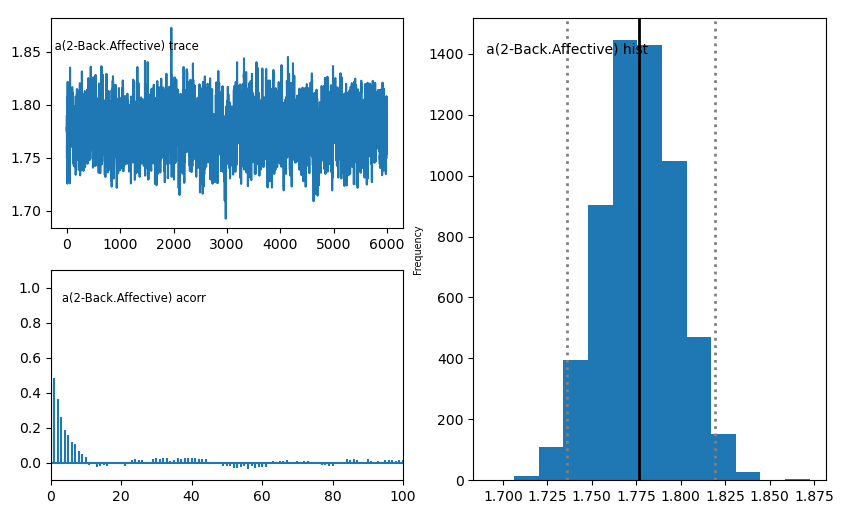

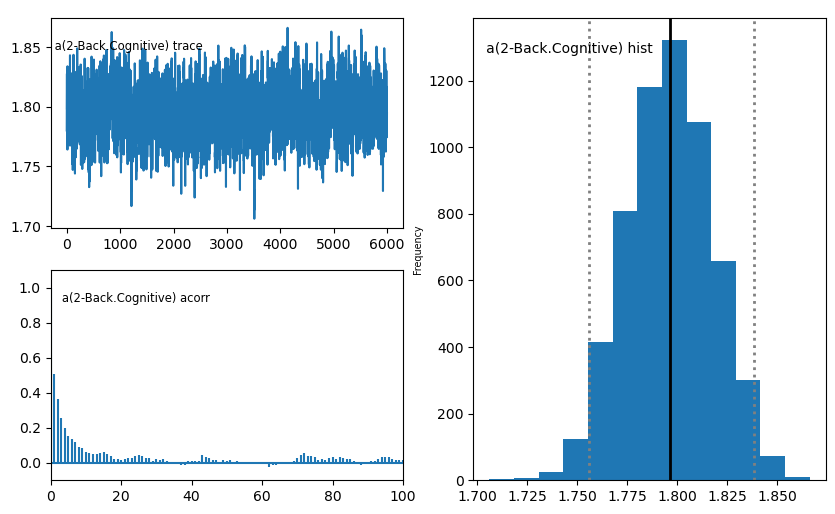

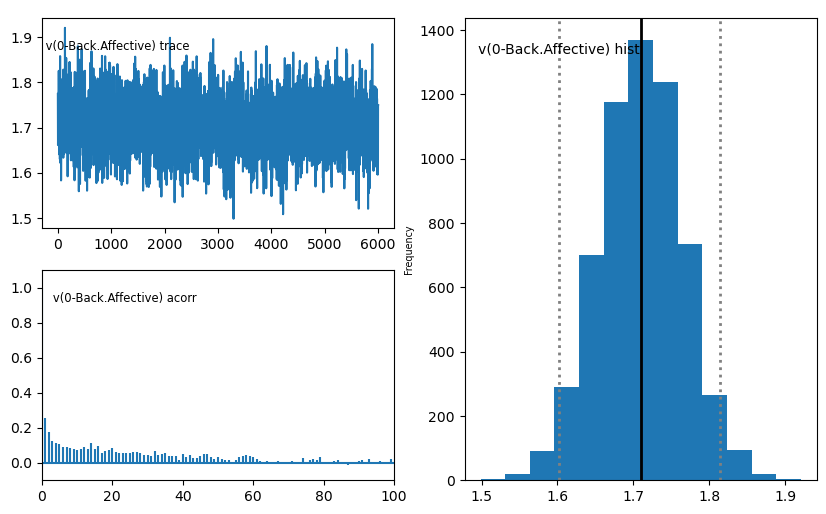

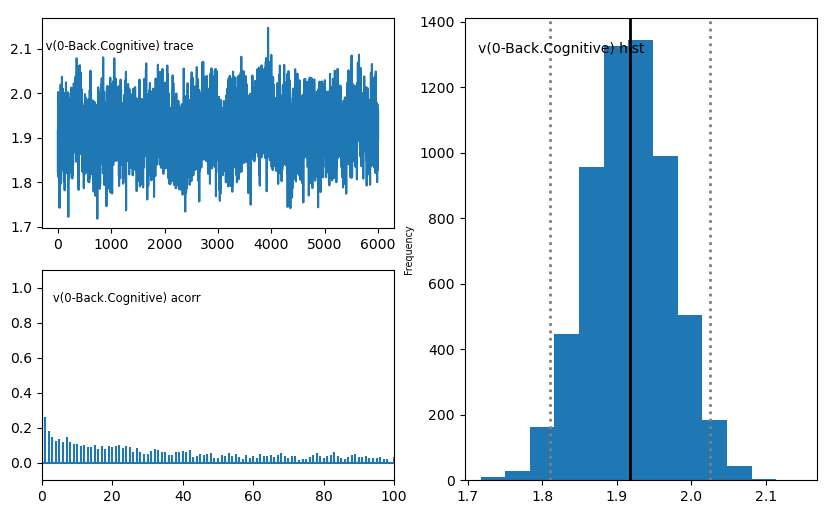

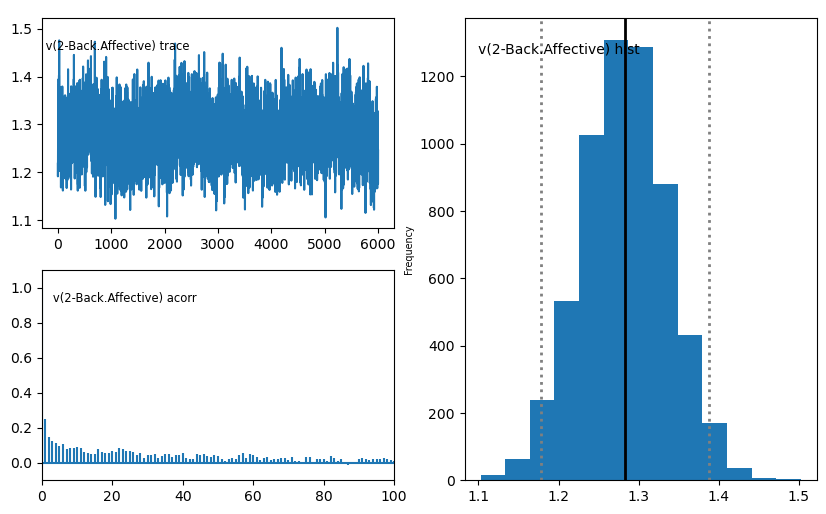

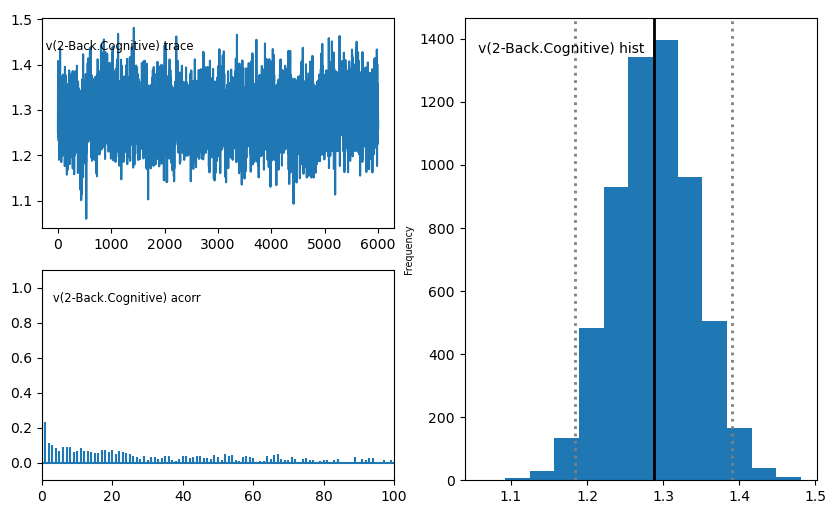

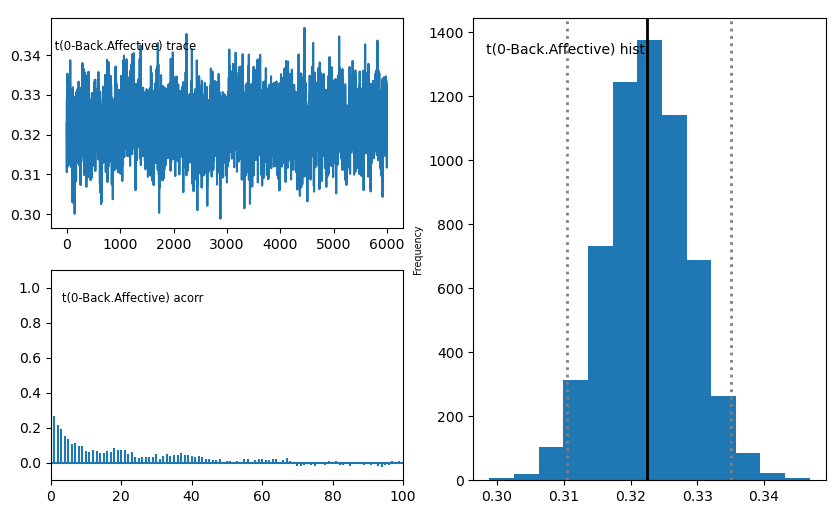

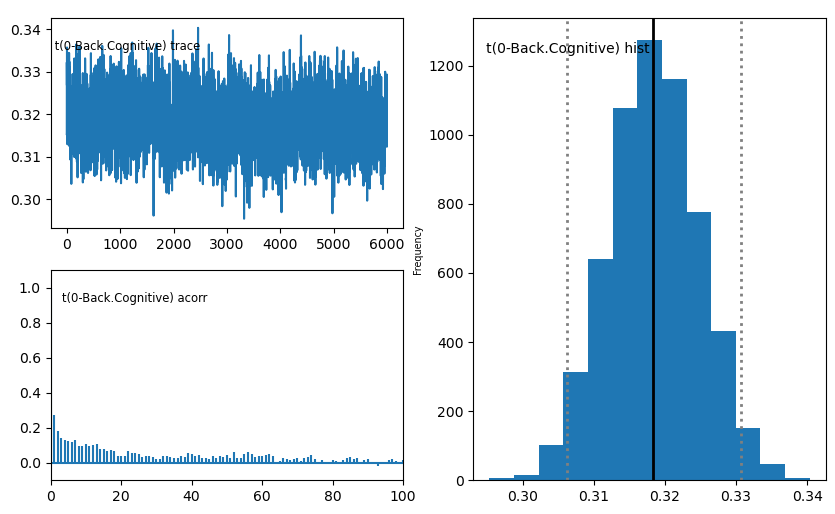

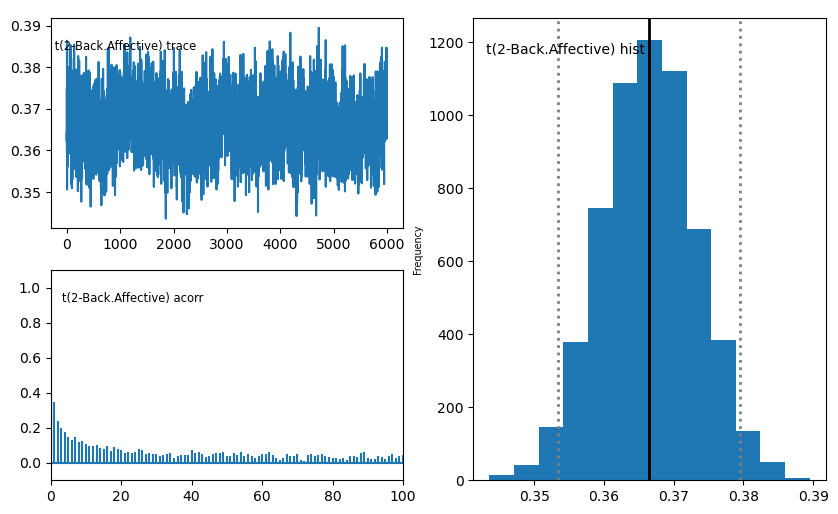

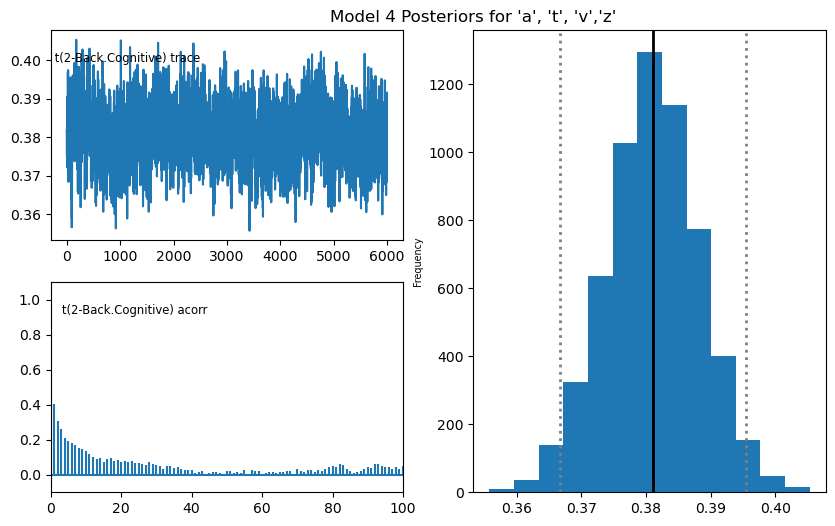

Plotting posteriors for Model 5...
Plotting a(0-Back.Affective)
Plotting a(0-Back.Cognitive)
Plotting a(2-Back.Affective)
Plotting a(2-Back.Cognitive)
Plotting v(0-Back.Affective)
Plotting v(0-Back.Cognitive)
Plotting v(2-Back.Affective)
Plotting v(2-Back.Cognitive)
Plotting t(0-Back.Affective)
Plotting t(0-Back.Cognitive)
Plotting t(2-Back.Affective)
Plotting t(2-Back.Cognitive)


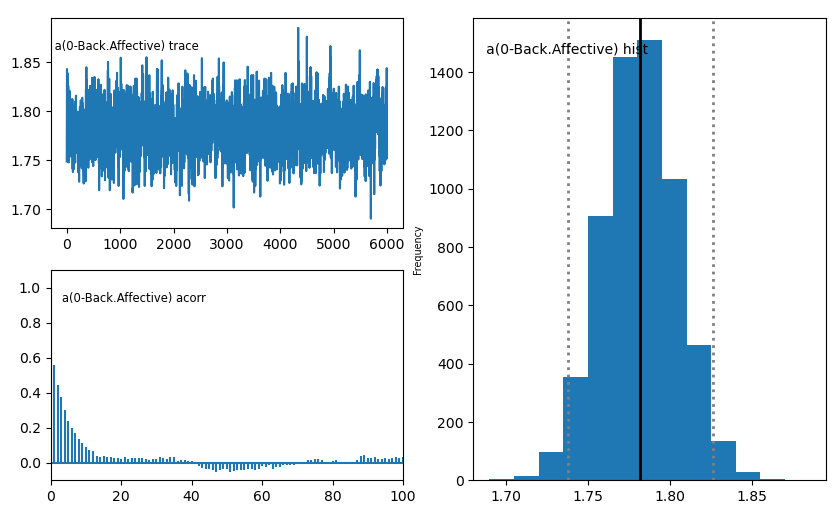

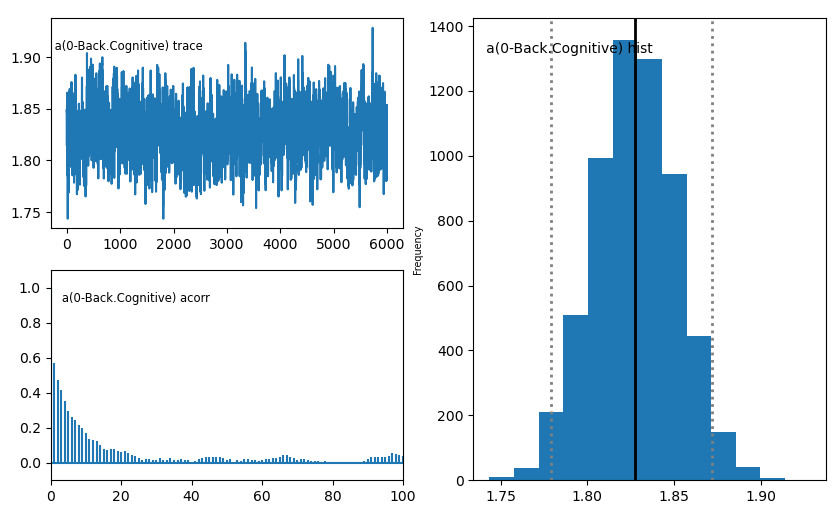

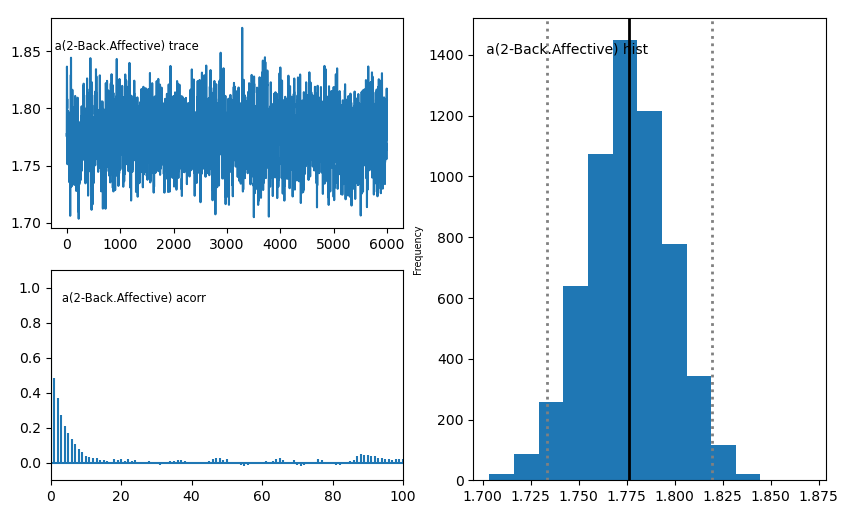

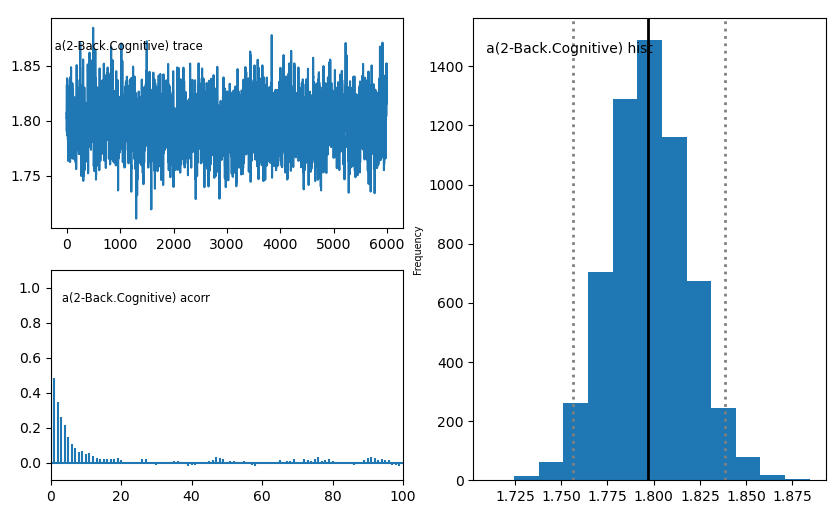

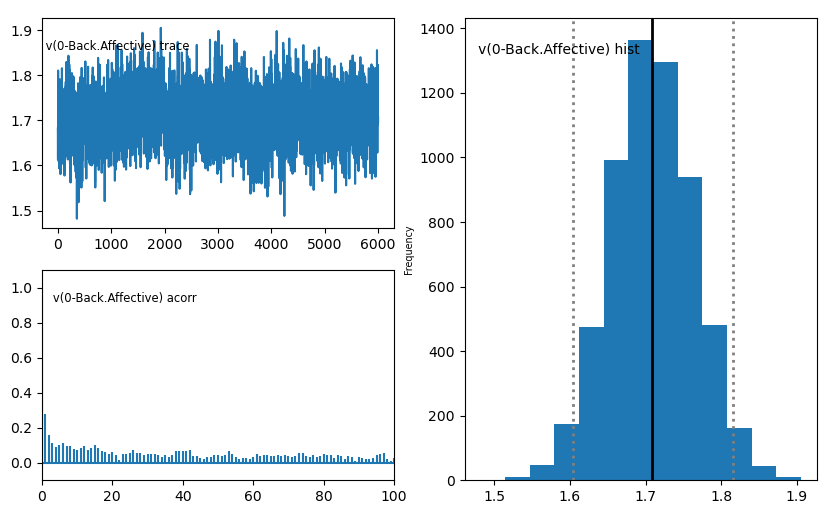

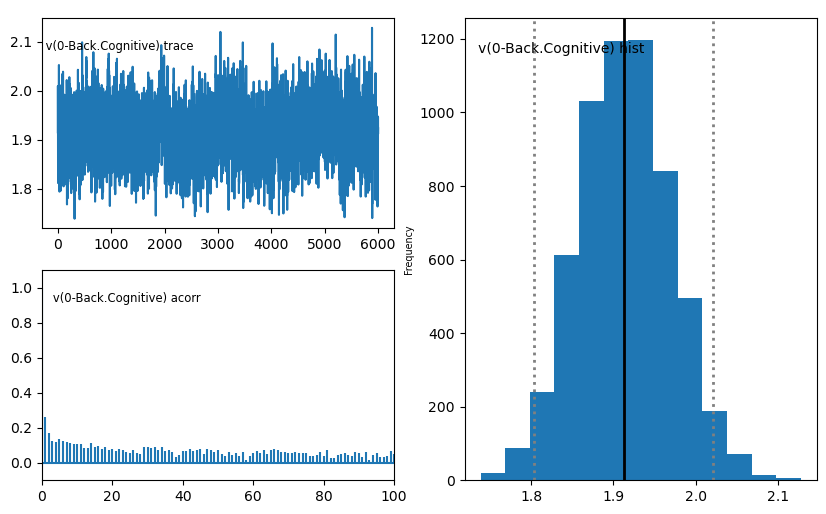

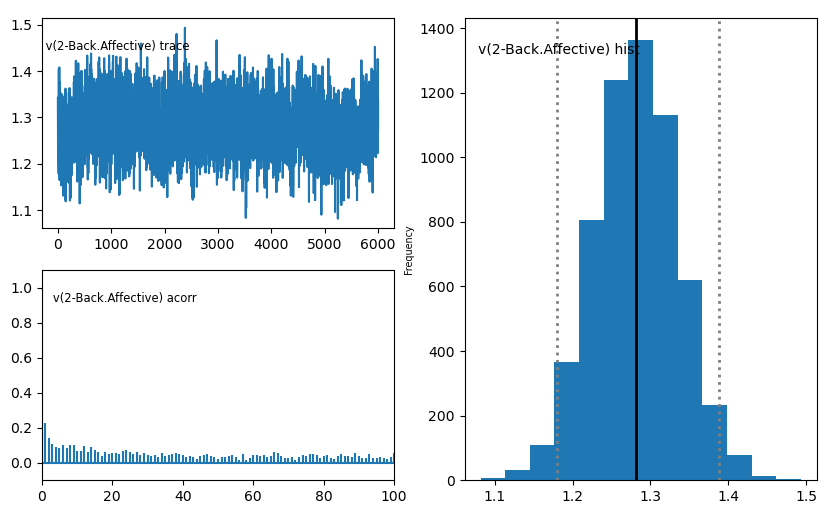

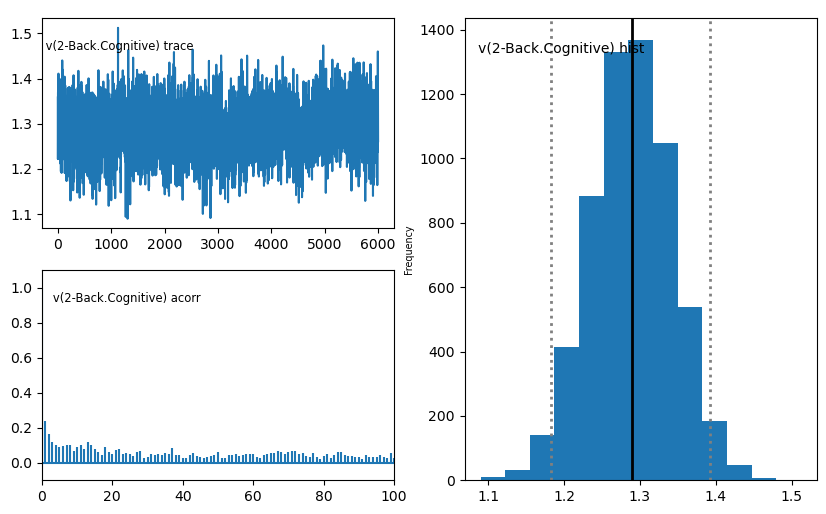

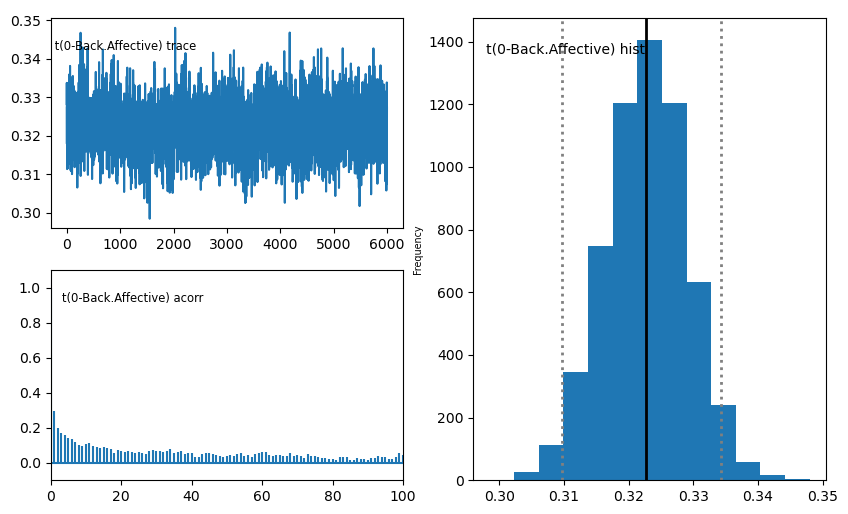

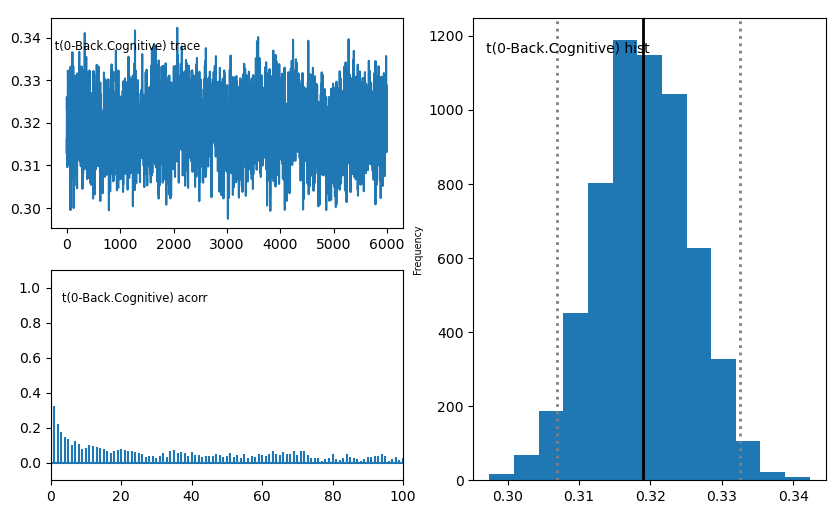

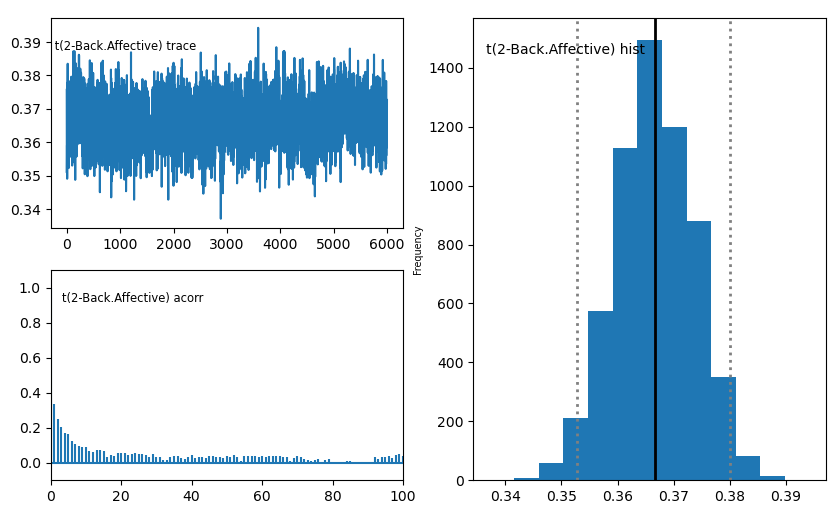

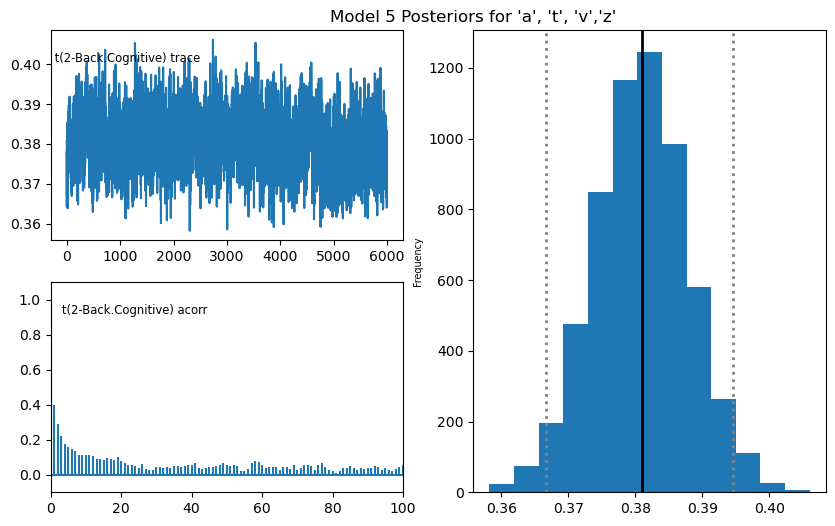

In [45]:
#Visual convergence check

for i, model in enumerate(models):
    print(f"Plotting posteriors for Model {i+1}...")
    model.plot_posteriors(['a', 't', 'v'])
    plt.title(f"Model {i+1} Posteriors for 'a', 't', 'v','z'")
    plt.show()

the parameters of the DDM map onto different cognitive processes: speed-accuracy settings (boundary separation a), response bias (starting point z), information processing speed (drift rate d), and non-decision time (Ter). These parameters are sometimes called “free parameters,” in the sense that they can take on different values (“freely”) – and just like the knobs on a stereo, changing each parameter affects DDM behavior.

P(v.0-Back.Affective > v.0-Back.Cognitive) =  0.004333333333333333
P(v.0-Back.Cognitive > v.0-Back.Affective) =  0.9956666666666667
P(v.2-Back.Affective > v.2-Back.Cognitive) =  0.4578333333333333
P(v.2-Back.Cognitive > v.2-Back.Affective) =  0.5421666666666667
P(v.0-Back.Affective > v.2-Back.Affective) =  1.0
P(v.0-Back.Cognitive > v.2-Back.Cognitive) =  1.0
P(v.2-Back.Affective > v.0-Back.Affective) =  0.0
P(v.2-Back.Cognitive > v.0-Back.Cognitive) =  0.0


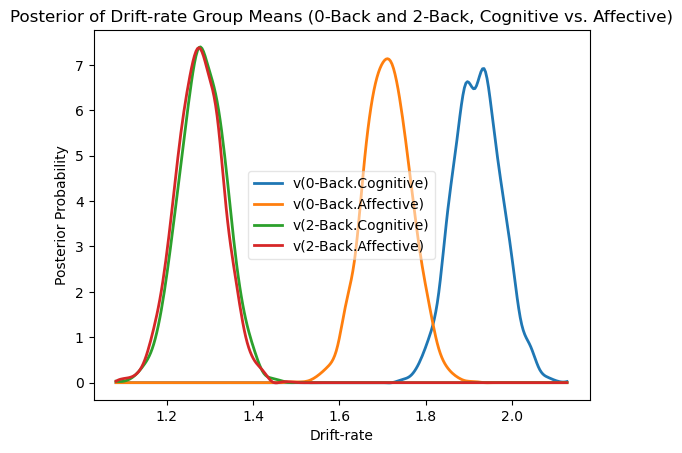

In [46]:
v_0Back_Aff, v_0Back_Cog = model.nodes_db.node[['v(0-Back.Affective)', 'v(0-Back.Cognitive)']]
v_2Back_Aff, v_2Back_Cog = model.nodes_db.node[['v(2-Back.Affective)', 'v(2-Back.Cognitive)']]

# Plot the posterior distributions for each condition
hddm.analyze.plot_posterior_nodes([v_0Back_Cog, v_0Back_Aff, v_2Back_Cog, v_2Back_Aff])

# Add labels and title to the plot
plt.xlabel('Drift-rate')
plt.ylabel('Posterior Probability')
plt.title('Posterior of Drift-rate Group Means (0-Back and 2-Back, Cognitive vs. Affective)')

print("P(v.0-Back.Affective > v.0-Back.Cognitive) = ", (v_0Back_Aff.trace() > v_0Back_Cog.trace()).mean())
print("P(v.0-Back.Cognitive > v.0-Back.Affective) = ", (v_0Back_Cog.trace() > v_0Back_Aff.trace()).mean())

print("P(v.2-Back.Affective > v.2-Back.Cognitive) = ", (v_2Back_Aff.trace() > v_2Back_Cog.trace()).mean())
print("P(v.2-Back.Cognitive > v.2-Back.Affective) = ", (v_2Back_Cog.trace() > v_2Back_Aff.trace()).mean())

print("P(v.0-Back.Affective > v.2-Back.Affective) = ", (v_0Back_Aff.trace() > v_2Back_Aff.trace()).mean())
print("P(v.0-Back.Cognitive > v.2-Back.Cognitive) = ", (v_0Back_Cog.trace() > v_2Back_Cog.trace()).mean())

print("P(v.2-Back.Affective > v.0-Back.Affective) = ", (v_2Back_Aff.trace() > v_0Back_Aff.trace()).mean())
print("P(v.2-Back.Cognitive > v.0-Back.Cognitive) = ", (v_2Back_Cog.trace() > v_0Back_Cog.trace()).mean())


By convention, the lower boundary is assigned a value of 0 on the y-axis and distance to the upper boundary is defined by a parameter representing boundary separation (a). Larger values of a mean that the decision-making process must travel further (up or down) to reach a boundary. The effect of larger a is thus that decision-making will be slower and more cautious: slower because more evidence is required before a distant boundary is reached and a response is triggered, and higher accuracy because it will be rare for the decision process to “mistakenly” cross the wrong boundary (Lerche et al., 2020). Boundary separation is in arbitrary units, but is often assumed to range from about 0.5–2. It is often assumed that the degree of boundary separation is at least partly under conscious control, depending on whether there is an emphasis on speed (low a) or accuracy (high a).

P(a.0-Back.Affective > a.0-Back.Cognitive) =  0.0725
P(a.0-Back.Cognitive > a.0-Back.Affective) =  0.9275
P(a.2-Back.Affective > a.2-Back.Cognitive) =  0.2385
P(a.2-Back.Cognitive > a.2-Back.Affective) =  0.7615
P(a.0-Back.Affective > a.2-Back.Affective) =  0.575
P(a.0-Back.Cognitive > a.2-Back.Cognitive) =  0.8396666666666667
P(a.2-Back.Affective > a.0-Back.Affective) =  0.425
P(a.2-Back.Cognitive > a.0-Back.Cognitive) =  0.16033333333333333


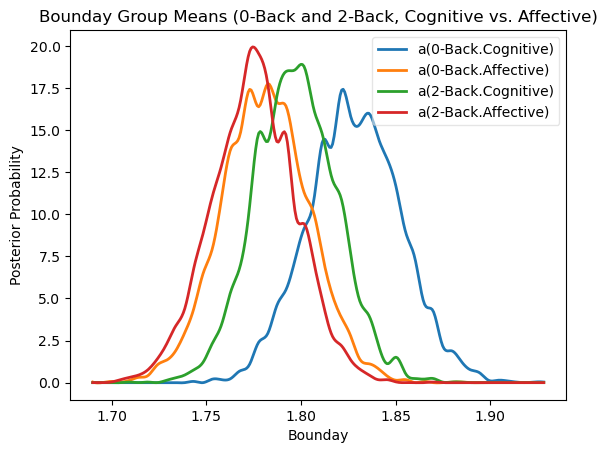

In [47]:
a_0Back_Aff, a_0Back_Cog = model.nodes_db.node[['a(0-Back.Affective)', 'a(0-Back.Cognitive)']]
a_2Back_Aff, a_2Back_Cog = model.nodes_db.node[['a(2-Back.Affective)', 'a(2-Back.Cognitive)']]

# Plot the posterior distributions for each condition
hddm.analyze.plot_posterior_nodes([a_0Back_Cog, a_0Back_Aff, a_2Back_Cog, a_2Back_Aff])

# Add labels and title to the plot
plt.xlabel('Bounday')
plt.ylabel('Posterior Probability')
plt.title('Bounday Group Means (0-Back and 2-Back, Cognitive vs. Affective)')

print("P(a.0-Back.Affective > a.0-Back.Cognitive) = ", (a_0Back_Aff.trace() > a_0Back_Cog.trace()).mean())
print("P(a.0-Back.Cognitive > a.0-Back.Affective) = ", (a_0Back_Cog.trace() > a_0Back_Aff.trace()).mean())

print("P(a.2-Back.Affective > a.2-Back.Cognitive) = ", (a_2Back_Aff.trace() > a_2Back_Cog.trace()).mean())
print("P(a.2-Back.Cognitive > a.2-Back.Affective) = ", (a_2Back_Cog.trace() > a_2Back_Aff.trace()).mean())

print("P(a.0-Back.Affective > a.2-Back.Affective) = ", (a_0Back_Aff.trace() > a_2Back_Aff.trace()).mean())
print("P(a.0-Back.Cognitive > a.2-Back.Cognitive) = ", (a_0Back_Cog.trace() > a_2Back_Cog.trace()).mean())

print("P(a.2-Back.Affective > a.0-Back.Affective) = ", (a_2Back_Aff.trace() > a_0Back_Aff.trace()).mean())
print("P(a.2-Back.Cognitive > a.0-Back.Cognitive) = ", (a_2Back_Cog.trace() > a_0Back_Cog.trace()).mean())

P(t.0-Back.Affective > t.0-Back.Cognitive) =  0.6578333333333334
P(t.0-Back.Cognitive > t.0-Back.Affective) =  0.3421666666666667
P(t.2-Back.Affective > t.2-Back.Cognitive) =  0.07866666666666666
P(t.2-Back.Cognitive > t.2-Back.Affective) =  0.9213333333333333
P(t.0-Back.Affective > t.2-Back.Affective) =  0.0
P(t.0-Back.Cognitive > t.2-Back.Cognitive) =  0.0
P(t.2-Back.Affective > t.0-Back.Affective) =  1.0
P(t.2-Back.Cognitive > t.0-Back.Cognitive) =  1.0


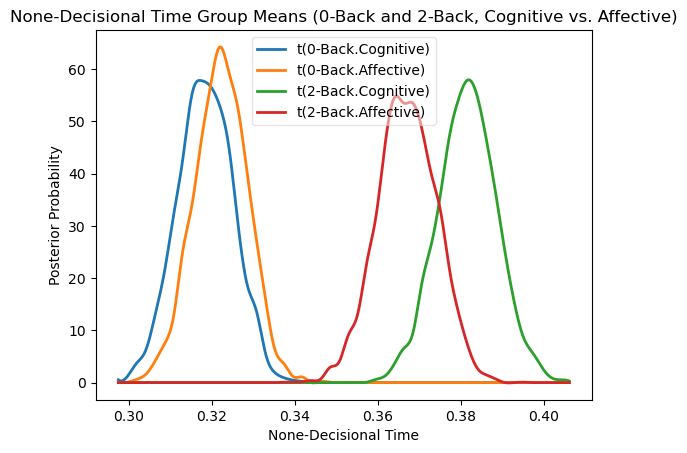

In [48]:
t_0Back_Aff, t_0Back_Cog = model.nodes_db.node[['t(0-Back.Affective)', 't(0-Back.Cognitive)']]
t_2Back_Aff, t_2Back_Cog = model.nodes_db.node[['t(2-Back.Affective)', 't(2-Back.Cognitive)']]

# Plot the posterior distributions for each condition
hddm.analyze.plot_posterior_nodes([t_0Back_Cog, t_0Back_Aff, t_2Back_Cog, t_2Back_Aff])

# Add labels and title to the plot
plt.xlabel('None-Decisional Time')
plt.ylabel('Posterior Probability')
plt.title('None-Decisional Time Group Means (0-Back and 2-Back, Cognitive vs. Affective)')

print("P(t.0-Back.Affective > t.0-Back.Cognitive) = ", (t_0Back_Aff.trace() > t_0Back_Cog.trace()).mean())
print("P(t.0-Back.Cognitive > t.0-Back.Affective) = ", (t_0Back_Cog.trace() > t_0Back_Aff.trace()).mean())

print("P(t.2-Back.Affective > t.2-Back.Cognitive) = ", (t_2Back_Aff.trace() > t_2Back_Cog.trace()).mean())
print("P(t.2-Back.Cognitive > t.2-Back.Affective) = ", (t_2Back_Cog.trace() > t_2Back_Aff.trace()).mean())

print("P(t.0-Back.Affective > t.2-Back.Affective) = ", (t_0Back_Aff.trace() > t_2Back_Aff.trace()).mean())
print("P(t.0-Back.Cognitive > t.2-Back.Cognitive) = ", (t_0Back_Cog.trace() > t_2Back_Cog.trace()).mean())

print("P(t.2-Back.Affective > t.0-Back.Affective) = ", (t_2Back_Aff.trace() > t_0Back_Aff.trace()).mean())
print("P(t.2-Back.Cognitive > t.0-Back.Cognitive) = ", (t_2Back_Cog.trace() > t_0Back_Cog.trace()).mean())


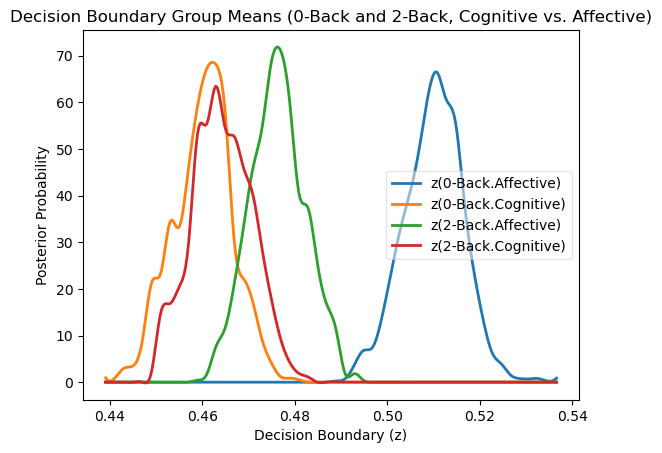

P(z.0-Back.Affective > z.0-Back.Cognitive) =  1.0
P(z.0-Back.Cognitive > z.0-Back.Affective) =  0.0
P(z.2-Back.Affective > z.2-Back.Cognitive) =  0.8946666666666667
P(z.2-Back.Cognitive > z.2-Back.Affective) =  0.10533333333333333
P(z.0-Back.Affective > z.2-Back.Affective) =  1.0
P(z.0-Back.Cognitive > z.2-Back.Cognitive) =  0.31783333333333336
P(z.2-Back.Affective > z.0-Back.Affective) =  0.0
P(z.2-Back.Cognitive > z.0-Back.Cognitive) =  0.6821666666666667


In [49]:
z_0Back_Aff, z_0Back_Cog = model.nodes_db.node[['z(0-Back.Affective)', 'z(0-Back.Cognitive)']]
z_2Back_Aff, z_2Back_Cog = model.nodes_db.node[['z(2-Back.Affective)', 'z(2-Back.Cognitive)']]

# Plot the posterior distributions for each condition
hddm.analyze.plot_posterior_nodes([z_0Back_Aff, z_0Back_Cog, z_2Back_Aff, z_2Back_Cog])

# Add labels and title to the plot
plt.xlabel('Decision Boundary (z)')
plt.ylabel('Posterior Probability')
plt.title('Decision Boundary Group Means (0-Back and 2-Back, Cognitive vs. Affective)')
plt.show()

# Calculate probabilities for the 0-Back conditions
print("P(z.0-Back.Affective > z.0-Back.Cognitive) = ", (z_0Back_Aff.trace() > z_0Back_Cog.trace()).mean())
print("P(z.0-Back.Cognitive > z.0-Back.Affective) = ", (z_0Back_Cog.trace() > z_0Back_Aff.trace()).mean())

# Calculate probabilities for the 2-Back conditions
print("P(z.2-Back.Affective > z.2-Back.Cognitive) = ", (z_2Back_Aff.trace() > z_2Back_Cog.trace()).mean())
print("P(z.2-Back.Cognitive > z.2-Back.Affective) = ", (z_2Back_Cog.trace() > z_2Back_Aff.trace()).mean())

print("P(z.0-Back.Affective > z.2-Back.Affective) = ", (z_0Back_Aff.trace() > z_2Back_Aff.trace()).mean())
print("P(z.0-Back.Cognitive > z.2-Back.Cognitive) = ", (z_0Back_Cog.trace() > z_2Back_Cog.trace()).mean())

print("P(z.2-Back.Affective > z.0-Back.Affective) = ", (z_2Back_Aff.trace() > z_0Back_Aff.trace()).mean())
print("P(z.2-Back.Cognitive > z.0-Back.Cognitive) = ", (z_2Back_Cog.trace() > z_0Back_Cog.trace()).mean())